In [2]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict, Counter

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

import pickle

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


# from google.colab import drive
# drive.mount('/content/gdrive')
import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
from NN_utils import BigTable, WeightClip

def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = numpy.exp(diffs)/(1.0+ numpy.exp(diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def calc_probs(s,q):
    zmask = numpy.isclose(q,-10).astype(int)
    diff = s-q
    prs = 1.0/(1.0+ numpy.exp(-diff))
    prs = numpy.maximum(zmask,prs)
    # print(prs)
    if len(q.shape)>1 and len(q.shape[0]) > 1:
      raise Exception("tensor is wrong shape, duh")
      # pr = pr.reshape(len(q))
    pr = numpy.prod(prs)
    return pr, zmask

# home = "/content/gdrive/My Drive/Colab Notebooks"
home="."
work_dir="pfa_models"

import pandas
mapping = pandas.read_csv(home+"/real_data/qn_act_map.csv")
mapping.index = mapping.qn_id
# mapping.drop("qn_id", axis=1, inplace=True)
print(mapping[0:100])

started
                                     qn_id     activity_name  \
qn_id                                                          
Dialogue 1~1.0              Dialogue 1~1.0        Dialogue 1   
Dialogue 1~2.0              Dialogue 1~2.0        Dialogue 1   
Dialogue 1~3.0              Dialogue 1~3.0        Dialogue 1   
Dialogue 1~4.0              Dialogue 1~4.0        Dialogue 1   
Dialogue 1~5.0              Dialogue 1~5.0        Dialogue 1   
Minimal pairs 1~1.0    Minimal pairs 1~1.0   Minimal pairs 1   
Minimal pairs 1~2.0    Minimal pairs 1~2.0   Minimal pairs 1   
Minimal pairs 1~3.0    Minimal pairs 1~3.0   Minimal pairs 1   
Minimal pairs 1~4.0    Minimal pairs 1~4.0   Minimal pairs 1   
Minimal pairs 1~5.0    Minimal pairs 1~5.0   Minimal pairs 1   
Minimal pairs 1~6.0    Minimal pairs 1~6.0   Minimal pairs 1   
Minimal pairs 1~7.0    Minimal pairs 1~7.0   Minimal pairs 1   
Minimal pairs 1~8.0    Minimal pairs 1~8.0   Minimal pairs 1   
Minimal pairs 1~9.0    Minimal p

In [3]:
# def create_databundle():
# if True:
#     raw_df = pandas.read_csv(home+"/real_data/Worksheet_1041.csv")
#     print(raw_df.columns)
#     print(len(raw_df))
#     raw_df = raw_df[raw_df.event_type=="answer_submitted"]
#     print(len(raw_df))


In [4]:
def progress_one_step(q,s, s_gammas):
  pr, zmask = calc_probs(s,q)
  active_in_q = 1-zmask
  # print(active_in_q)
  # print("pr is", pr)
  passed = 0
  if (numpy.random.random() <= pr):
    passed = 1
  s= s + s_gammas*active_in_q # learning rates from a successful attempt
  # else:
  #   s= s + s_rhos*active_in_q # learning rates from an unsauccessful attempt
  return passed, pr, s

In [5]:
def run_data(students, questions, gammas, model_to_train=None):
  from collections import defaultdict, Counter
  sixs = []
  qixs = []
  hits = []
  outps = []
  
  r = -1
  scores = defaultdict(int)
  hit_counter = {}
  
  s_indices = range(len(students))
  # bo_selecta = None
  for six in s_indices:
    print("running student, ", six)
    s = students[six]
    R = 0  # reset reward for new student
    ball_bag = list(range(len(questions)))
    while ball_bag:
      # print("WSH",s.shape)
      # print(numpy.mean(s), numpy.min(s), numpy.max(s))
      # for sval in s:
      #   print(sval)
      # raise Exception("WANK")
      # if bo_selecta is None:
      bo_selecta = random.choice(ball_bag)
      q = questions[bo_selecta]
      passed, pr, s_ = progress_one_step(q,s, gammas[six])
      students[six] = s_ # Crucially, update the student to make progress...
      # print(six, bo_selecta, numpy.mean(students[six]), pr)
      if passed:
        # print("***PASSED***", six, bo_selecta, pr)
        ball_bag.remove(bo_selecta)

      # hit_counter[(six, bo_selecta)] += 1
      # hit_counter
    
      if six not in hit_counter:
        print("INIT'G zeros FOR", six)
        hit_counter[six] = [int(0)]*n_questions #numpy.zeros(n_questions, dtype="uint8")

      sixs.append( [int(six)])
      qixs.append([int(bo_selecta)])
      hits.append( tuple(hit_counter[six]) )
      outps.append( [int(passed)] )

      # neue = hit_counter[six]
      # neue[bo_selecta] += 1
      hit_counter[six][bo_selecta] += 1

      R += r
      # bo_selecta = None
    print(R)
    scores[six] = R

  # if model_to_train:
  #   phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
  #   mae = abs(pr - phat)
  #   print(pr, phat, mae)
  #   model_to_train.train_on_batch( [ [six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ], [passed] )
 
  # print("Die Arrays werden in Numpy Datentypen verwandelt.")
  # sixs = numpy.array(sixs, dtype="uint8")
  # qixs = numpy.array(qixs, dtype="uint8")
  # hits = numpy.array(hits, dtype="uint8")
  # outps = numpy.array(outps, dtype="uint8")

  # print(hits.shape)
  # print(outps.shape)

  # if model_to_train:
    # phat = model_to_train.predict([[six], [bo_selecta], [hit_counter[(six,bo_selecta)]] ])
    # mae = abs(pr - phat)
    # print(pr, phat, mae)
    # model_to_train.fit( inps, outps )
  # for (k,v) in scores.items():
  #   print(k,v)
  print("Der Lauf is beendet.")
  vals = list(scores.values())
  return numpy.mean(vals), sixs, qixs, hits, outps


In [6]:
from keras.regularizers import l1
from keras.layers import Reshape, Dense, Dropout, add, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, concatenate, Flatten, Maximum, Multiply, dot, Layer
from keras import backend as K, Model
from keras.initializers import RandomUniform, RandomNormal


def binary_regulariser(x):
    return K.sum( 1.0-(4.0*K.pow((0.5 - x),2)) )
    # return K.sum(K.log(2*x) +K.log(2*(1-x)))
    # return K.log(2*x) +K.log(2*(1-x))

    
    
    
from keras import backend as K
def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
    true_positives = K.sum(y_true * y_pred) + K.epsilon()
    possible_positives = K.sum(y_true) + K.epsilon()
    recall = true_positives / possible_positives
    return recall

def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) + K.epsilon()
    true_positives = K.sum(y_true * y_pred) + K.epsilon()
    predicted_positives = K.sum(y_pred) + K.epsilon()
    precision = true_positives / predicted_positives
    return precision

def f1_metric(y_true, y_pred, average="macro"):
    precision_1 = precision_m(y_true, y_pred)
    recall_1 = recall_m(y_true, y_pred)
#     print("p/r 1", K.eval(precision_1), K.eval(recall_1))
    f1_1 = 2.0*precision_1*recall_1 / (precision_1+recall_1)
#     print("f1_1", K.eval(f1_1))
    if average=="macro":
        precision_0 = precision_m((1-y_true), (1-y_pred))
        recall_0 = recall_m((1-y_true), (1-y_pred))
#         print("p/r 0", K.eval(precision_0), K.eval(recall_0))
        f1_0 = 2.0*precision_0*recall_0 / (precision_0+recall_0)
#         print("f1_0", K.eval(f1_0))
        f1 = (f1_1+f1_0)/2.0
#         print("f1  ", K.eval(f1))
        return f1
    else:
        return f1_1

def f1_loss(y_true, y_pred, average="macro"):
    return (1.0 - f1_metric(y_true, y_pred, average=average))
    


def generate_MLTM_raw_model(n_questions, n_students, row_w, ptqs=None, double_p=False,
                        loss="binary_crossentropy",
                        metrics=None, init50=True, deep_HEU=False, reg=None, use_q=False):
    print("MLTM RAW:\nROW W is ", row_w)
    print("reg is",reg)
    print(n_questions, n_students)

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.regularizers import L2,L1
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

    bin_clip = WeightClip(0.0,1.0)
    if use_q:
        Q = Embedding(n_questions , row_w, name="q_matrix", 
                embeddings_initializer=RandomUniform(0.99,1),
                 )
        q_jk = Flatten()(bin_clip( Q(qn_sel) ))
    
    
    if double_p:
        pass_counter = Input(shape=(n_questions, ), name="pass_counter", dtype="float32")
        fail_counter = Input(shape=(n_questions, ), name="fail_counter", dtype="float32")
        hit_counter = add([pass_counter, fail_counter], name="hit_counter")
    else:
        hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
        
#     long_clip = WeightClip(0,100)
    
    sp = pr_to_spread(.5, row_w, as_A_and_D=False)

    q_init = RandomNormal(mean= -sp/2) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, 
#                        embeddings_regularizer=L2(100.0/(n_questions*row_w)**2) if "l1" in reg else None, 
                       embeddings_initializer=q_init, name="qn_embedding")
    qn_row = Flatten()(qn_emb(qn_sel))

    #embeddings_initializer=RandomNormal(mean=1+sp)
    s_init = RandomNormal(mean= sp/2) if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, embeddings_initializer=s_init, 
                                    embeddings_regularizer=L2(5.5e-8) if reg=="l2" else None,
                                    name="alphas"
                                    )(psi_sel))
#     if deep_HEU:
#         h = Dense(row_w, use_bias=False, activation="relu")(hit_counter)
#         kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(h)
#     else:
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

    difs = subtract([psi_row, qn_row], name="difs")
    Prs = Lambda(lambda z: K.sigmoid(z))(difs)
    if use_q:
        Prs = Lambda(lambda mx: K.pow(mx[0],mx[1]))([Prs, q_jk])
    score = Lambda(lambda ps: K.exp(K.sum(K.log(ps), axis=-1, keepdims=True)))(Prs)
    
    if double_p:
        model = Model(inputs=[qn_sel, psi_sel, pass_counter, fail_counter], outputs=score)
    else:
        model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model


In [7]:
# def generate_MLTM0_model(n_questions, n_students, row_w, 
#                         loss="binary_crossentropy",
#                         metrics=None,
#                         l2=False):
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     from keras.regularizers import L1
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)
#     pos_clip = WeightClip(0.0000, 100)

#     base = 1
#     q_init = RandomNormal(mean=base)
#     qn_emb = Embedding(n_questions, row_w, embeddings_initializer=q_init, 
# #                        activity_regularizer=L1(1/row_w), 
#                        name="qn_embedding")
#     qn_row = Flatten(name="qn_row_out")(pos_clip(qn_emb(qn_sel)))
    
# # Q MAsking STilL reQuired
#     k=1000
#     qmask = Lambda(lambda x: K.clip(x*k,0.0000,1.0000))(qn_row)
    
#     alpha_row = Embedding(n_students, row_w, 
#                           embeddings_initializer=RandomNormal(mean=base+sp), name="alphas",
#                           )(psi_sel)
#     gamma_row = Embedding(n_students, row_w, name="gammas")(psi_sel)
#     alpha_row = Flatten()(alpha_row)
#     gamma_row = Flatten()(gamma_row)

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])], name="psi_row_out")

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#     Prs = Lambda(lambda x: K.pow(x[0],K.abs(x[1])) )([Prs, qmask])

#     score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)

#     return model

In [8]:
# # def my_regularizer(x):
# #     return K.sum(K.square(x), axis=1)

# def generate_MLTMb_model(n_questions, n_students, row_w, 
#                         loss="binary_crossentropy",
#                         metrics=None,
#                         reg=None,
#                         reg_w = None):
#     print("MLTMb model with reg", reg)
#     print("ROW W is ", row_w)
#     # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
#     from keras.initializers import RandomNormal, RandomUniform, Constant
#     from keras.regularizers import L1,L2
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     sp = pr_to_spread(.5, row_w, as_A_and_D=False)

#     zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
#     bin_clip = WeightClip(0.0000, 1.0000)
# #     lam_clip = Lambda(lambda x: K.clip(x,0.0000,1.0000))
# #     long_clip = WeightClip(-100,100)
    
#     etas = Embedding(1, row_w, input_length=1, 
#                      embeddings_initializer=RandomNormal(0),
#                      name="skill_diffs")
    
#     l2_w = reg_w if (reg_w is not None) else 1.5e-06
#     effs = Embedding(n_questions, row_w, 
# #                      embeddings_constraint=WeightClip(0, 1), 
#                      embeddings_initializer=RandomUniform(0.999,1), 
#                      name="qn_embedding",
# #                      embeddings_initializer = RandomNormal(1),
# #                      embeddings_regularizer=L2(10000.0/(n_questions*row_w)**2) if reg=="l1" else None,
# #                      embeddings_regularizer=L1(l2_w/(n_questions*row_w)) #if reg=="l1" else None,
#                         activity_regularizer=L1(l2_w) #if reg=="l1" else None,
#                      )
    
# #     effs = Embedding(n_questions, row_w, name="qn_embedding")

# #     qn_row = Flatten(name="qn_row_out")(long_clip(etas(zer0(qn_sel))))
#     qn_row = Flatten(name="qn_row_out")(etas(zer0(qn_sel)))

# #     delta_loading_is_qmask = Flatten(name="qmask_out")(lam_clip(bin_clip(effs(qn_sel))))
# #     delta_loading_is_qmask = Flatten()(effs(qn_sel))
#     delta_loading_is_qmask = Flatten(name="qmask_out")(bin_clip(effs(qn_sel)))

# # Q MAsking STilL reQuired
    
    
#     alpha_row = Embedding(n_students, row_w, 
#                           embeddings_initializer=RandomNormal(sp), name="alphas",
# #                           embeddings_regularizer=L2(l2_w/(n_students*row_w)**2) if reg=="l2" else None,
# #                           embeddings_regularizer=L2(l2_w) if reg=="l2" else None,
# #                           embeddings_regularizer=L2(0.01) if reg=="l2" else None,
#                          )(psi_sel)
#     gamma_row = Embedding(n_students, row_w, name="gammas", 
#                           embeddings_initializer=RandomNormal(0),
#                          )(psi_sel)
#     alpha_row = Flatten()(alpha_row)
#     gamma_row = Flatten()(gamma_row)

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])], name="psi_row_out")

#     difs = subtract([psi_row, qn_row], name="difs")
#     Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#     Prs = Lambda(lambda x: K.pow(x[0],K.abs(x[1])) )([Prs, delta_loading_is_qmask])

#     score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
#     # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

#     model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
#     model.compile(optimizer="adam", loss=loss, metrics=metrics)

#     return model

In [9]:
def create_CFM_model(n_questions, n_students, row_w, loss="binary_crossentropy", sfocus=False, metrics=None, reg=False, ns=False):
    print("Using CFM model!")

    print("ROW W is ", row_w)
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.regularizers import L2
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0, 1)
#     bin_clip = Lambda(lambda c: K.clip(c,0,1))

    sp = pr_to_spread(.5, row_w, as_A_and_D=False)
    B = Embedding(1 , row_w, name="skill_diffs", embeddings_initializer=RandomNormal(1))
    theta_i = Flatten()(Embedding(n_students, 1, name="alphas", 
                                  embeddings_initializer=RandomNormal(1+sp),
#                                   embeddings_regularizer= L2(1/row_w) if ("l2" in reg) else None,
                                 )  (psi_sel))

    Q = Embedding(n_questions , row_w, name="qn_embedding", 
#                        embeddings_constraint=WeightClip(0, 1), 
                         embeddings_initializer=RandomUniform(0.99,1),
#                          activity_regularizer = "l1" if ("l1" in reg) else None,
                 )
    
    gamma_k = Flatten()(Embedding(1, row_w, name="gammas", embeddings_initializer=RandomNormal(0),)  (zer0(qn_sel)))

    beta_k = Flatten()(B( zer0(qn_sel) ))
    q_jk = Flatten()(bin_clip( Q(qn_sel) ))

    print("shape kc-gammas", gamma_k.shape)
    T_jk = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)

    if ns:
        skill_now = multiply([gamma_k, T_jk])
    else:
        skill_now = Add()([theta_i, multiply([gamma_k, T_jk])])
    
    logit_difs = subtract([skill_now, beta_k])
    
    print("logit shape", logit_difs.shape)
    Prs = Lambda(lambda z: K.sigmoid(z))(logit_difs)
    
    Prs = Lambda(lambda mx: K.pow(mx[0],mx[1]))([Prs, q_jk])
    
    print("Prs shape", Prs.shape)
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True))(Prs)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    from keras.optimizers import SGD, RMSprop, Nadam, Adam
    #   optr = SGD(learning_rate=1.0)#, momentum=0.01, nesterov=True)
    #   optr = RMSprop()
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)
    return model


In [10]:
#DEF PFFNN
def generate_PFFNN(n_questions, n_students, row_w, loss="binary_crossentropy", metrics=None, reg=None, 
                       mode="conjunctive", scalar_a = False):
    print(n_questions, n_students)
    
    from keras.initializers import RandomNormal, RandomUniform, Constant
#     from keras.regularizers import L2,L1
    from keras.layers import add
    from keras.regularizers import L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    
    
    pass_counter = Input(shape=(n_questions, ), name="pass_counter", dtype="float32")
    fail_counter = Input(shape=(n_questions, ), name="fail_counter", dtype="float32")

    bin_clip = WeightClip(0, 1)
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding")
    qn_row = Flatten()((qn_emb(qn_sel)))
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    rho_row = Flatten()(Embedding(n_students, row_w, name="rhos")(psi_sel))

    qP_practice = Dense(row_w, name="qP_loadings", use_bias=False)(pass_counter)
    qF_practice = Dense(row_w, name="qF_loadings", use_bias=False)(fail_counter)

    s_mod = Dense(row_w)(concatenate([qP_practice, gamma_row]))
    f_mod = Dense(row_w)(concatenate([qF_practice, rho_row]))
    prac_kc_mods = Dense(row_w)(concatenate([s_mod, f_mod]))
        
    alpha_row = Flatten()(Embedding(n_students, row_w,
                                    embeddings_regularizer=L2(5.5e-8) if reg=="l2" else None,
                                    name="alphas")(psi_sel))
    psi_row = add( [alpha_row, prac_kc_mods] )
#   

    difs = subtract([psi_row, qn_row], name="difs")
    score = Dense(1, activation="sigmoid")(difs)

    model = Model(inputs=[qn_sel, psi_sel, pass_counter, fail_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model


In [11]:
#DEF PFA
def generate_PFA_model(n_questions, n_students, row_w, loss="binary_crossentropy", metrics=None, reg=None, 
                       mode="conjunctive", scalar_a = False, use_q=True):
    print(n_questions, n_students)
    
    from keras.initializers import RandomNormal, RandomUniform, Constant
#     from keras.regularizers import L2,L1
    from keras.layers import add
    from keras.regularizers import L2
    from tensorflow.keras.layers import RepeatVector
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    
    
    pass_counter = Input(shape=(n_questions, ), name="pass_counter", dtype="float32")
    fail_counter = Input(shape=(n_questions, ), name="fail_counter", dtype="float32")

#     hit_counter = add([pass_counter, fail_counter])
#     hit_counter = fail_counter


    bin_clip = WeightClip(0, 1)
#     bin_clip = Lambda(lambda c: K.clip(c,0,1))
    

    if mode in ["additive", "classic"]:
        sp = 0
    else:
        sp = pr_to_spread(.5, row_w, as_A_and_D=False)
    q_init = RandomNormal(mean=sp)
    s_init = RandomNormal(mean=sp+sp)
    
    Q = Embedding(n_questions , row_w, name="q_matrix", 
#                        embeddings_constraint=WeightClip(0, 1), 
                embeddings_initializer=RandomUniform(0.99,1),
#                          activity_regularizer = "l1" if ("l1" in reg) else None,
                 )
    q_jk = Flatten()(bin_clip( Q(qn_sel) ))
#     qn_w = 1 if mode in ["classic"] else row_w
    print("mode", mode)
    if mode in ["additive", "classic", "conjunctive"]:
        zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
        zer0_sel = zer0(qn_sel)
        qn_emb = Embedding(1, row_w, embeddings_initializer=q_init, name="skill_diffs")
        qn_row = Flatten()(qn_emb(zer0_sel))
        print("mode", mode, "created skill_diffs")
    
        gamma_row = Flatten()(Embedding(1, row_w, name="gammas")(zer0_sel))
        rho_row = Flatten()(Embedding(1, row_w, name="rhos")(zer0_sel))

    else:
#         q_jk = None
        print("mode", mode, "created qn_embedding")
        qn_emb = Embedding(n_questions, row_w, embeddings_initializer=q_init, name="qn_embedding")
        qn_row = Flatten()((qn_emb(qn_sel)))
        gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
        rho_row = Flatten()(Embedding(n_students, row_w, name="rhos")(psi_sel))

    qP_practice = Dense(row_w, name="qP_loadings", use_bias=False)(pass_counter)
    qF_practice = Dense(row_w, name="qF_loadings", use_bias=False)(fail_counter)

    #     suc_prac = Lambda(lambda x: (x[0]*x[1]))([qP_practice, gamma_row])
#     fai_prac = Lambda(lambda x: (x[0]*x[1]))([qF_practice, rho_row])
#     prac_kc_mods = add([suc_prac, fai_prac])                  
    prac_kc_mods = add([ multiply([qP_practice, gamma_row]), multiply([qF_practice, rho_row]) ])
#     prac_kc_mods = Lambda(lambda x: (x[0]*x[1]) + (x[2]*x[3]))([qP_practice, gamma_row, qF_practice, rho_row])

#     kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
#     print("shape kc-practice", kc_practice.shape)
    
#     if mode != "classic":
#         a_w = 1
#     else:

        
    if mode == "classic":
        print("USing NO A0, classic mode")
        a_w = 0
        psi_row = prac_kc_mods
    else:
        if scalar_a:
            print("Using scalar A0")
            a_w = 1
        else:
            a_w = row_w
        print("USing A0, with width", a_w)
        if reg=="l2":
            print("regularisation l2")
        alpha_row = Flatten()(Embedding(n_students, a_w, 
                                        embeddings_initializer=s_init,
                                        embeddings_regularizer=L2(5e-6/row_w) if reg=="l2" else None,
                                        name="alphas")(psi_sel))
        if mode=="conjunctive":
            psi_row = add( [alpha_row, prac_kc_mods] )
        elif a_w > 1:
            psi_row = add( [alpha_row, prac_kc_mods] )
        else:
            #add scalar alpha later
            psi_row = prac_kc_mods
#         if a_w == 1:
#             alpha_row = Flatten()(RepeatVector(row_w)(alpha_row))
#         psi_row = Lambda(lambda x: x[0]+x[1])( [alpha_row, prac_kc_mods] )
        
    difs = subtract([psi_row, qn_row], name="difs")
#     difs = Lambda(lambda x: x[0] - x[1], name="difs")([psi_row, qn_row])

#     if mode=="additive":
#         sum_of_logits = Lambda(lambda logits: K.sum(logits, axis=-1, keepdims=True))(difs)
#         score = Lambda(lambda z: K.sigmoid(z))(sum_of_logits)
    if mode=="conjunctive":
        print("Conj combo mode")
#         long_clip = WeightClip(-10, 10)
#         qn_row = long_clip(qn_row)
        difs = subtract([psi_row, qn_row], name="difs")
        Prs = Lambda(lambda z: K.sigmoid(z))(difs)
        if use_q:
            Prs = Lambda(lambda a: K.pow(a[0],a[1]))([Prs, q_jk])
        score = Lambda(lambda ps: K.prod(ps, axis=-1, keepdims=True))(Prs)
#         score = Lambda(lambda ps: K.exp(K.sum(K.log(ps), axis=-1, keepdims=True)))(Prs)

#     elif mode=="slp":
# #         qn_masked = Lambda(lambda a: a[0]*a[1])([qn_row, q_jk])
#         difs = Lambda(lambda x: x[0] - x[1], name="difs")([psi_row, qn_row])
#         score = Dense(1, activation="sigmoid")(difs)
#     elif mode=="sigslp":
# #         qn_masked = Lambda(lambda a: a[0]*a[1])([qn_row, q_jk])
# #         difs = Lambda(lambda a: a[0]*a[1])([difs, q_jk])
#         difs = Lambda(lambda x: x[0] - x[1], name="difs")([psi_row, qn_row])
#         Prs = Lambda(lambda z: K.sigmoid(z))(difs)
#         score = Dense(1, activation="sigmoid")(Prs)
#     elif mode=="concat":
#         if use_q and (q_jk is not None):
#             qn_row = Lambda(lambda a: a[0]*a[1])([qn_row, q_jk])
#         inpwt = concatenate([psi_row, qn_row])
#         score = Dense(1, activation="sigmoid")(inpwt)
#     elif mode=="concat3":
# #         if use_q and (q_jk is not None):
# #             difs = Lambda(lambda a: a[0]*a[1])([difs, q_jk])
#         inpwt = concatenate([psi_row, qn_row, difs, q_jk])
# #         h = Dense(row_w, activation="sigmoid")(inpwt)
#         score = Dense(1, activation="sigmoid")(inpwt)

    elif mode in ["classic", "additive"]:
        print("class/add mode")

#         difs = subtract([psi_row, qn_row], name="difs")
        if q_jk is not None:
            difs = Lambda(lambda a: a[0]*a[1])([difs, q_jk])
        sum_of_logits = Lambda(lambda logits: K.sum(logits, axis=-1, keepdims=True))(difs)
        if a_w == 1:
            #for scalar a0, adjust model level here
            sum_of_logits = add( [alpha_row, sum_of_logits] )
        score = Lambda(lambda z: K.sigmoid(z))(sum_of_logits)
        
    model = Model(inputs=[qn_sel, psi_sel, pass_counter, fail_counter], outputs=score)
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model


In [12]:
def create_AFM_model(n_questions, n_students, row_w, loss="binary_crossentropy", 
                     sfocus=False, metrics=None, reg=None, ns=False):
    print("Using {}AFM model!".format("S" if sfocus else ""))
    print("reg is", reg)
    
    #AFM
    # p_ij = sig( a_i + sum[k in KC(j)] b_k + g_k*n_ik )
    
    #sAFM
    # p_ij = sig( sum[k in KC(j)] a_ik + b_k + g_k*n_ik )
    
    print("ROW W is ", row_w)
    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.regularizers import L2,L1
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0.0000,1.0000)
    
    skill_d_ws = Embedding(1 , row_w, name="skill_diffs", embeddings_initializer=RandomNormal(0))
#   a0 = 5
    qn_mx = Embedding(n_questions , row_w, name="qn_embedding", 
#                        embeddings_constraint=WeightClip(0, 1), 
                       embeddings_initializer=RandomUniform(0.99,1),
#                        activity_regularizer="l1" if ("l1" in reg) else None,
                     )
    
    gamma_row = Embedding(1, row_w, name="gammas",
                    embeddings_initializer=RandomNormal(0),
                    )(zer0(psi_sel))
    
    if not ns:
        a0 = Embedding(n_students, 1, name="alphas", 
                      embeddings_initializer=RandomNormal(0),
    #                   embeddings_regularizer= L2(1/n_students) if ("l2" in reg) else None,
                      )(psi_sel)

    etas = Flatten()( skill_d_ws(zer0(qn_sel)) ) 
    
    q_mask = Flatten()( bin_clip(qn_mx(qn_sel)) )

    gamma_row = Flatten()(gamma_row)
    print("shape kc-gammas", gamma_row.shape)
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    prac_modifier = Multiply()([kc_practice, gamma_row])

    difs = subtract([prac_modifier, etas])
    difs = Multiply()([difs, q_mask]) # mask off irrelevant KCs
    
    print("Difs shape", difs.shape)
    summed = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="lambda_sums")(difs)
    print("Summed shape", summed.shape)
    
    if not ns:
        a0 = Flatten()(a0)
        logit = Add()([a0, summed]) #in AFM we add a0 after the subtraction and masking
    else:
        logit = summed
        
    print("logit shape", logit.shape)
    score = Lambda(lambda z: K.sigmoid(z))(logit)
    
    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    from keras.optimizers import Adam
    #   optr = SGD(learning_rate=1.0)#, momentum=0.01, nesterov=True)
    #   optr = RMSprop()
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)
    return model



def create_AFMg_model(n_questions, n_students, row_w, loss="binary_crossentropy", metrics=None, reg=None):
    print("Using AFMg model!")

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.optimizers import Adam
    from keras.regularizers import L2
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

    zer0 = Lambda(lambda x: K.cast(K.clip(x,0,0), dtype="int32"))
    bin_clip = WeightClip(0,1)

    q_row = Flatten()(bin_clip(Embedding(n_questions , row_w, name="qn_embedding", 
                                         embeddings_initializer=RandomUniform(.95,1),
                                         activity_regularizer= "l1" if ("l1" in reg) else None)(qn_sel)))

    skill_d_ws = Embedding(1 , row_w, name="skill_diffs")    
    base_deltas = Flatten()(skill_d_ws(zer0(qn_sel)))
#     masked_deltas = multiply([q_row, base_deltas])
#     delta = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_deltas")(masked_deltas)

    
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
        
    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    prac_kc_mods = multiply([kc_practice, gamma_row])
#     masked_kc_mods = multiply([prac_kc_mods, q_row])
#     practice = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kc_mods)
    
    kcwise_difs = subtract([prac_kc_mods, base_deltas])
    masked_kcwise_difs = multiply([kcwise_difs, q_row])
    dif = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True), name="sum_kc_pracs")(masked_kcwise_difs)
    
    a0 = Flatten()(Embedding(n_students, 1, name="alphas",
                            embeddings_regularizer=L2(1/n_students) if ("l2" in reg) else None)(psi_sel))
    logit_dif = add([a0, dif])

    score = Lambda(lambda z: K.sigmoid(z))(logit_dif)
    
    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)

    return model







In [13]:
def create_RASCH_model(n_questions, n_students, loss="binary_crossentropy", metrics=None, pf=False, dropout=0):
    print("Using univariate Rasch model!")

    from keras.initializers import RandomNormal, RandomUniform, Constant
    from keras.layers import Add, Reshape, Multiply
    from keras.constraints import NonNeg
    from keras.optimizers import Adam
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    
    if pf:
        print("RASCH PF mode activated")
        pass_counter = Input(shape=(n_questions, ), name="pass_counter", dtype="float32")
        fail_counter = Input(shape=(n_questions, ), name="fail_counter", dtype="float32")
        kc_practice_S = Dense(1, name="qP_loadings", use_bias=False)(pass_counter)
        kc_practice_F = Dense(1, name="qF_loadings", use_bias=False)(fail_counter)
#         if dropout>0:
#             kc_practice_S = Dropout(dropout)(kc_practice_S)
#             kc_practice_F = Dropout(dropout)(kc_practice_F)
        gamma_row = Flatten()(Embedding(n_students, 1, name="gammas")(psi_sel))
        rho_row = Flatten()(Embedding(n_students, 1, name="rhos")(psi_sel))
    else:
        print("RASCH LF mode activated")
        hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
        kc_practice = Dense(1, name="qk_loadings", use_bias=False)(hit_counter)
        gamma_row = Flatten()(Embedding(n_students, 1, name="gammas")(psi_sel))
    
    delta = Flatten()(Embedding(n_questions , 1, name="qn_embedding")(qn_sel))
#     gamma_row = Flatten()(Embedding(n_students, 1, name="gammas")(psi_sel))
    a0 = Flatten()(Embedding(n_students, 1, name="alphas")(psi_sel))

    if pf:
        alpha = add([a0, multiply([kc_practice_S, gamma_row]), multiply([kc_practice_F, rho_row])])
    else:
        alpha = add([a0, multiply([kc_practice, gamma_row])])
        
    if dropout>0:
        alpha = Dropout(dropout)(alpha)
        
    logit_dif = subtract([alpha, delta])

    score = Lambda(lambda z: K.sigmoid(z))(logit_dif)
    
    if pf:
        model = Model(inputs=[qn_sel, psi_sel, pass_counter, fail_counter], outputs=score)
    else:
        model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    optr = Adam()
    model.compile(optimizer=optr, loss=loss, metrics=metrics)

    return model

In [14]:
numpy.iinfo("uint16")

iinfo(min=0, max=65535, dtype=uint16)

In [15]:
from keras.layers import Dropout

def custom_avl2_inner(x):
    return None
#     return lam * tensorflow.math.reduce_mean(tensorflow.math.square(x))

#     return custom_avl2_inner
reg_w = 1
def custom_avl2(x):
    row_mean = tensorflow.math.reduce_mean(tensorflow.math.reduce_mean(tensorflow.math.square(x), axis=0))
    return reg_w * row_mean

def generate_PFM_MLP_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None, reg_w=None, dropout=0):
    sp = pr_to_spread(.5, row_w, as_A_and_D=False)

    print("MLP model")
    if reg=="l2":
        print("L2 reg'n", reg)
        if reg_w is None:
            reg_w = (1/sp)**2
        else:
            reg_w = (reg_w/sp)**2
#         reg_w = (1/sp)**2
        print("reg_w=", reg_w)
        def custom_avl2(x):
            mn = tensorflow.math.reduce_mean(tensorflow.math.square(x))
            return reg_w * mn
#             return reg_w * tensorflow.math.reduce_mean(tensorflow.math.square(x))

    psi_sel = Input(shape=(1,), name="psi_select", dtype="int16")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int16")
    
    pass_counter = Input(shape=(n_questions, ), name="pass_counter", dtype="float32")
    fail_counter = Input(shape=(n_questions, ), name="fail_counter", dtype="float32")  
#     hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     from keras.regularizers import L2

        
#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding",
#                        embeddings_regularizer=L2(0.000001) if reg=="l2" else None,
                       embeddings_initializer=RandomNormal(-sp))
    qn_row = Flatten()(qn_emb(qn_sel))

#     l2_w = reg_w if (reg_w is not None) else 0.1
    
#     embeddings_initializer=RandomNormal(mean=1+sp)
#     s_init = RandomNormal(mean=sp) #if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    rho_row = Flatten()(Embedding(n_students, row_w, name="rhos")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                embeddings_initializer=RandomNormal(0),
                                embeddings_regularizer=custom_avl2 if reg=="l2" else None,
#                                 embeddings_regularizer=L2(l2_w/(n_students*row_w)) if reg=="l2" else None,
#                                 embeddings_regularizer=L2(5e-5/row_w) if reg=="l2" else None, 
                                )(psi_sel))

#     pass_counterh = Dropout(0.2)(pass_counter)
    qP_practice = Dense(row_w, name="qP_loadings", use_bias=False)(pass_counter)
    qP_practice = Dropout(0.2)(qP_practice)
    
#     fail_counterh = Dropout(0.2)(fail_counter)
    qF_practice = Dense(row_w, name="qF_loadings", use_bias=False)(fail_counter)
    qF_practice = Dropout(0.2)(qF_practice)
    
    psi_row = add( [alpha_row,  multiply([qP_practice,gamma_row]),  multiply([qF_practice,rho_row])] )
    if dropout>0:
        print("using dropout = ", dropout)
        psi_row = Dropout(dropout)(psi_row)
    
    difs = subtract([psi_row, qn_row], name="difs")
#     if deep:
#         h = Dense(max(2,row_w//20), activation="relu")(difs)
# #         h = Dense(5, activation="relu")(h)
#     else:
    h = difs
#     h = Dropout(0.5)(difs)
    score = Dense(1, activation="sigmoid")(h)

    model = Model(inputs=[qn_sel, psi_sel, pass_counter, fail_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [16]:
def generate_MLP_model(n_questions, n_students, row_w, ptqs=None, loss=f1_loss, non_neg=False,
                       metrics=None, deep=False, concat=False, reg=None, reg_w=None):
    print("MLP model")
    sp = pr_to_spread(.5, row_w, as_A_and_D=False)    
    if reg=="l2":
        print("L2 reg'n", reg)
        if reg_w is None:
            reg_w = (1/sp)**2
        else:
            reg_w = (reg_w/sp)**2
#         reg_w = (1/sp)**2
        print("reg_w=", reg_w)
        def custom_avl2(x):
#             row_mean = tensorflow.math.reduce_mean(tensorflow.math.reduce_mean(tensorflow.math.square(x), axis=0))
            mn = tensorflow.math.reduce_mean(tensorflow.math.square(x))
            return reg_w * mn
        
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    hit_counter = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")

#     q_init = RandomNormal(mean=0) if init50 else "uniform"
    qn_emb = Embedding(n_questions, row_w, name="qn_embedding", embeddings_initializer=RandomNormal(-sp))
    qn_row = Flatten()(qn_emb(qn_sel))

    l2_w = reg_w if (reg_w is not None) else 0.1
    
    from keras.regularizers import L2
    #embeddings_initializer=RandomNormal(mean=1+sp)
    s_init = RandomNormal(mean=sp) #if init50 else "uniform"
    gamma_row = Flatten()(Embedding(n_students, row_w, name="gammas")(psi_sel))
    alpha_row = Flatten()(Embedding(n_students, row_w, name="alphas",
                                embeddings_initializer=RandomNormal(sp),
                                embeddings_regularizer=custom_avl2 if reg=="l2" else None,
#                                 embeddings_regularizer=L2(l2_w/(n_students*row_w)) if reg=="l2" else None,
#                                 embeddings_regularizer=L2(5e-5/row_w) if reg=="l2" else None, 
                                    
                                )(psi_sel))

    kc_practice = Dense(row_w, name="qk_loadings", use_bias=False)(hit_counter)
    print("shape kc-practice", kc_practice.shape)
    
    psi_row = add( [alpha_row, multiply([kc_practice, gamma_row])])

    difs = subtract([psi_row, qn_row], name="difs")
#     if deep:
#         h = Dense(max(2,row_w//20), activation="relu")(difs)
# #         h = Dense(5, activation="relu")(h)
#     else:
    h = difs
    score = Dense(1, activation="sigmoid")(h)

    model = Model(inputs=[qn_sel, psi_sel, hit_counter], outputs=score)
    
    model.compile(optimizer="adam", loss=loss, metrics=metrics)

    return model

In [17]:
#   o_sixs, o_qixs, o_chits, o_out = 
def convert_to_indices_and_ohe(o_sixs, o_qixs, o_chits, o_out, sid_six_lookup, qid_qix_lookup, PFA=True, pre_history=None):
#     o_sixs = [sid_six_lookup[sid] for sid in o_sixs]
#     o_qixs = [qid_qix_lookup[qid] for qid in o_qixs]
#     o_ixs = [sid_six_lookup[sid] for sid in o_sixs]
    import copy
    
    if pre_history is None:
        history_lookup = {}
    else:
        history_lookup = pre_history    

    max_qix = max(qid_qix_lookup.values())+1
    print("MAX QIX is", max_qix)
    for six in set(o_sixs):
        if six not in history_lookup:
            onehot_pass_hist = [0]*max_qix
            onehot_fail_hist = [0]*max_qix
            history_lookup[six] = ( onehot_pass_hist, onehot_fail_hist )
        
    chits_onehot = []
    if PFA:
        for six,qix,act in zip(o_sixs, o_qixs, o_chits):
            q, ob = act
            (onehot_pass_hist, onehot_fail_hist) = history_lookup[six]
#             onehot_pass_hist = copy.copy(onehot_pass_hist)
#             onehot_fail_hist = copy.copy(onehot_fail_hist)
            chits_onehot.append((copy.copy(onehot_pass_hist), copy.copy(onehot_fail_hist)))
            if qix is not None:
                print(q, ", qix is", qix)
                if ob==1:
                    onehot_pass_hist[qix]+=1
                else:
                    onehot_fail_hist[qix]+=1
            history_lookup[six] = (onehot_pass_hist, onehot_fail_hist)
    else:
        raise Exception("non-PFA no longer supported, sorry!")
#         for six in set(o_sixs):
#             history_lookup[six] = [0]*max_qix
#         for six,qix,act in zip(o_sixs, o_qixs, o_chits):
#             q, ob = act
#             qix = qid_qix_lookup[q]
#             onehot_pass_hist = history_lookup[six]
#             chits_onehot.append(copy.copy(onehot_pass_hist))
#             if qix is not None:
#                 onehot_pass_hist[qix] +=1
#             history_lookup[six] = onehot_pass_hist
#     o_out = o_out
    o_sixs = numpy.array(o_sixs, dtype="int16")
    o_qixs = numpy.array(o_qixs, dtype="int16")
    chits_onehot = numpy.array(chits_onehot, dtype="int8")
    o_out = numpy.array(o_out, dtype="int8")
    return o_sixs, o_qixs, chits_onehot, o_out, history_lookup


In [18]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [19]:
# def split_next_step(sixs, qixs, hout, max_students=None, alternate=True, balance_training=True, min_hist=0, max_hist=None):

#     def convert_to_np(s,q,o):
#         s = numpy.array(s, dtype="uint16")
#         q = numpy.array(q, dtype="uint16")
#         o = numpy.array(o, dtype='uint8')
#         return s,q,o

#     sid_six_lookup = {}
#     qid_qix_lookup = {}

#     print("splitting in progress")
#     o_sixs, o_qixs, o_chits, o_out = [],[],[],[]
#     v_sixs, v_qixs, v_chits, v_out = [],[],[],[]
#     t_sixs, t_qixs, t_chits, t_out = [],[],[],[]
#     for_validate = True

# #     qixs = [q.split("~")[0] for q in qixs]
#     qids = numpy.array(qixs)

#     # to_iterate = unique_sixs if (max_students is None) else unique_sixs[0:max_students] 
#     unique_sixs = numpy.unique(sixs)
#     print(len(unique_sixs))
#     cnt = 0
    
#     sixs = numpy.array(sixs)
    
#     six_pointer = 0
#     qix_pointer = 0
#     print("iterating...")

#     for six in unique_sixs:
#         if six not in sid_six_lookup:
#             sid_six_lookup[six]=six_pointer
#             six_pointer+=1
#         # sindices = sixs[sixs==six]
#         sindices = numpy.where(sixs==six)[0]
#         if len(sindices) < (1+min_hist):
#             continue
#         if max_hist is not None:
#             sindices = sindices[0:max_hist+1]
# #         sindices = [i for i in range(len(sixs)) if sixs[i]==six]
# #         print(qids)
# #         print(sindices)
# #         print(len(sindices), len(qids))
        
#         these_qids = qids[sindices]
#         sub_history = []
#         for qid in these_qids:
#             sub_history.append(sub_history[-1]+[qid] if sub_history else [None])
#             if qid not in qid_qix_lookup:
#                 qid_qix_lookup[qid] = qix_pointer
#                 qix_pointer+=1

# #         print("For", six, "there are n_atts:", len(sindices))
#         last_sindex = int(sindices[-1]) # isolate the last attempt for testing
#         last_qix = qids[last_sindex]
    
#     # print("last qix is", last_qix)
#     # print(last_qix in qixs)
#     # matches = [1 if q==last_qix else 0 for q in qixs]
# #         n_attempts_on_q = numpy.sum(qids==last_qix)
#         # n_attempts_on_q = sum(matches)
# #         if len(sindices) > 0:
# #             print("For",six,":", len(sindices),"~ with n on last_sindex (", last_sindex, ")=", n_attempts_on_q)
# #             cnt+=1
#         last_history = sub_history[-1]
#         other_indices = sindices[0:-1]
#         other_histories = sub_history[0:-1]
#         if alternate and for_validate:
#             v_sixs.append(sixs[last_sindex])
#             v_qixs.append(qids[last_sindex])
#             v_chits.append(last_history)
#             v_out.append(hout[last_sindex])
#             for_validate = False
#         else:
#             t_sixs.append(sixs[last_sindex])
#             t_qixs.append(qids[last_sindex])
#             t_chits.append(last_history)
#             t_out.append(hout[last_sindex])
#             for_validate = True
# #         else:
# #             continue
# #             other_indices = sindices # keep them all in training
# #             other_histories = sub_history

#         # cnt += (len(other_indices) + 1)
#         o_sixs.extend([sixs[int(i)] for i in other_indices])
#         o_qixs.extend([qids[int(i)] for i in other_indices])
#     #     o_chits.extend([chits[int(i)] for i in other_indices])
#         o_chits.extend(other_histories)
#         o_out.extend([hout[int(i)] for i in other_indices])
#         cnt+= len(other_indices)
        
# #         print(cnt)
#         if max_students and cnt > max_students:
#             break
        
# #         if balance_training:
# #             z_ixs = numpy.where(numpy.array(o_out)==0)[0]
# #             one_ixs = numpy.nonzero(o_out)[0]
# #             numpy.random.shuffle(one_ixs)
# #             balanced_ixs = numpy.concatenate([z_ixs, one_ixs[0:len(z_ixs)]])
# #             o_sixs = [o_sixs[i] for i in balanced_ixs]
# #             o_qixs = [o_qixs[i] for i in balanced_ixs]
# #             #     o_chits = [o_chits[i] for i in balanced_ixs]
# #             o_out = [o_out[i] for i in balanced_ixs]

# #         if not alternate:
# #             from sklearn.model_selection import train_test_split
# #             other_indices, v_indices = train_test_split(list(range(len(o_out))), test_size=0.01, random_state=666, stratify=o_out)
# #             v_sixs = [o_sixs[int(i)] for i in v_indices]
# #             v_qixs = [o_qixs[int(i)] for i in v_indices]
# #             #     v_chits = [o_chits[int(i)] for i in v_indices]
# #             v_out = [o_out[int(i)] for i in v_indices]
# #             o_sixs = [o_sixs[int(i)] for i in other_indices]
# #             o_qixs = [o_qixs[int(i)] for i in other_indices]
# #             #     o_chits = [o_chits[int(i)] for i in other_indices]
# #             o_out = [o_out[int(i)] for i in other_indices]
    
#     print("sid six lookup", getsize(sid_six_lookup))
#     print("qid qix lookup", getsize(qid_qix_lookup))
#     print("o_chits", getsize(o_chits))
    
#     o_sixs, o_qixs, o_chits, o_out = convert_to_indices_and_ohe(o_sixs, o_qixs, o_chits, o_out, sid_six_lookup, qid_qix_lookup)
#     v_sixs, v_qixs, v_chits, v_out = convert_to_indices_and_ohe(v_sixs, v_qixs, v_chits, v_out, sid_six_lookup, qid_qix_lookup)
#     t_sixs, t_qixs, t_chits, t_out = convert_to_indices_and_ohe(t_sixs, t_qixs, t_chits, t_out, sid_six_lookup, qid_qix_lookup)

#     print("type of ochits")
#     print(type(o_chits))
        
#     print("splut -", len(o_out), len(v_out), len(t_out))
#     print("max indices are:")
#     print(max(o_sixs),max(v_sixs),max(t_sixs))
#     print(max(o_qixs),max(v_qixs),max(t_qixs))

#     # for ts,tq in zip(t_sixs, t_qixs):
#     c = Counter()
#     for tq in numpy.unique(t_qixs):
#         for os,oq in zip(o_sixs, o_qixs):
#             if oq==tq:
#                 c[tq] += 1
#     commoners = c.most_common()
#     for q,_c in commoners:
#         print(q, _c)

# #   return ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), c)
#     return ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), sid_six_lookup, qid_qix_lookup)

In [20]:
def split_next_step2(sixs, qixs, hout, max_students=None, alternate=True, balance_training=True, 
                          min_hist=0, max_hist=None, split_for_PFA=True, stratify=False):
    
#     thatll_do_pig = False

    def convert_to_np(s,q,o):
        s = numpy.array(s, dtype="uint16")
        q = numpy.array(q, dtype="uint16")
        o = numpy.array(o, dtype='uint8')
        return s,q,o

    sid_six_lookup = {}
    qid_qix_lookup = {}

    print("splitting in progress")
    o_sixs, o_qixs, o_chits, o_out = [],[],[],[]
    n_sixs, n_qixs, n_chits, n_out = [],[],[],[]
    v_sixs, v_qixs, v_chits, v_out = [],[],[],[]
    t_sixs, t_qixs, t_chits, t_out = [],[],[],[]

#     qixs = [q.split("~")[0] for q in qixs]
    qids = numpy.array(qixs)

    # to_iterate = unique_sixs if (max_students is None) else unique_sixs[0:max_students] 
    unique_sixs = numpy.unique(sixs)
    print(len(unique_sixs))
    cnt = 0
    
    sixs = numpy.array(sixs)
    
    six_pointer = 0
    qix_pointer = 0
    print("iterating...")

    for sid in unique_sixs:            
        sindices = numpy.where(sixs==sid)[0]
        if len(sindices) < (1+min_hist):
            continue
        if max_hist is not None:
            sindices = sindices[0:max_hist+1]
        
        if sid not in sid_six_lookup:
            sid_six_lookup[sid]=six_pointer
            six_pointer+=1
        
        these_qids = [qids[i] for i in sindices]
        these_outs = [hout[i] for i in sindices]
        
        sub_history = []
#         sub_sindices = []
#         qid_cnt = Counter()
        seen_qs = set()
        dedupe=False
        print("len of these_qids:", len(these_qids))
        for qid,ob in zip(these_qids, these_outs):
        
# #             if qid in seen_qs:
# #                 print("seen q {} under s {} before aye".format(qid,sid))
# #             else:
#             if True:
# #                 sub_sindices.append(sindx)
            if not dedupe:
                sub_history.append((qid,ob))
            elif qid not in seen_qs:
                sub_history.append((qid,ob))
                seen_qs.add(qid)
#                 qid_cnt[qid] += 1
#                 last_qid = qid
#                 last_ob = ob
#                 seen_qs.add(qid)
            if qid not in qid_qix_lookup:
                qid_qix_lookup[qid] = qix_pointer
                qix_pointer+=1
        print("post clip len of these_qids:", len(sub_history))

        trim=False
        if trim:
            seen_qs = set()
            print(sid, "len orig subhist", len(sub_history))
    #         full_subh = copy.copy(sub_history)
            previous_qs = [pr[0] for pr in sub_history]
            ix=0
            while ix<len(previous_qs):
                pq = previous_qs[ix]
                if pq in seen_qs:
                    break
                else:
                    seen_qs.add(pq)
                    ix+=1

            sub_history = sub_history[0:ix]    
            print(sid, "len de-duped (trimmed) subhist", len(sub_history))
                
#         print("For", six, "there are n_atts:", len(sindices))
#         last_sindex = int(sub_sindices[-1]) # isolate the last attempt for testing
#         last_qix = qids[last_sindex]
        
    
#         last_history = sub_history[-1]
#         other_indices = sub_sindices[0:-1]
#         other_histories = sub_history[0:-1]
        
#         print("oh", other_histories)
#         print("last QIX", last_qix, type(last_qix))
#         print(type(sub_history))
#         print("sub    hist:", sub_history)
#         print("other hists:", other_histories)

        (last_qid, last_ob)   = sub_history[-1]
        sub_history = sub_history[0:-1]

        six = sid_six_lookup[sid]
        previous_qs = [pr[0] for pr in list(sub_history)]
        dupe_check = False
        if (not dupe_check) or (dupe_check and (last_qid not in previous_qs)):            
            n_sixs.append(six)
            n_qixs.append(qid_qix_lookup[last_qid])
            n_chits.append((last_qid, last_ob))
            n_out.append(last_ob)
        else:
            raise Exception("Shit on it")

        o_sixs.extend([six]*len(previous_qs))
        o_qixs.extend([qid_qix_lookup[q] for q in previous_qs])
        o_chits.extend(sub_history)
        o_out.extend([pair[1] for pair in sub_history])

        cnt+= len(sub_history)
        print("cnt!", cnt)
#         print(cnt)
#         if thatll_do_pig:
#             break

        if max_students and cnt > max_students:
            break
#             thatll_do_pig = True
            

#     print("SPOT CHECK")
#     print(n_sixs[0:10])
#     print(n_qixs[0:10])            
#     print(n_chits[0:10])
#     print(n_out[0:10])
#     print("@@@@")
#     print(o_sixs[0:10])
#     print(o_qixs[0:10])            
#     print(o_chits[0:10])
#     print(o_out[0:10])
#     raise Exception("Deliberately exception raised to halt work")

    v_counter = Counter()
    t_counter = Counter()
    mapping.index = mapping.qn_id
    for_v = True
    if alternate:
        for s,q,(qid,ob),o in zip(n_sixs, n_qixs, n_chits, n_out):
#             print("SQHO!")
#             print(s,q,(qid,ob),o)
            typ = "Unknown"
            
            try:
                typ = str(mapping.loc[qid].activity_skill)
                print(typ,": v=",v_counter[typ], " t=", t_counter[typ])
            except:
                print("type not found")
            
            if stratify:
                for_v = v_counter[typ] < t_counter[typ]

            if for_v:
                v_counter[typ]+=1
                v_sixs.append(s)
                v_qixs.append(q)
                v_chits.append((qid,ob))
                v_out.append(o)
                for_v = False
            else:
                t_counter[typ]+=1
                t_sixs.append(s)
                t_qixs.append(q)
                t_chits.append((qid,ob))
                t_out.append(o)
                for_v = True
                
    print("sid six lookup", getsize(sid_six_lookup))
    print("qid qix lookup", getsize(qid_qix_lookup))
    print("o_chits", getsize(o_chits))
    
    o_sixs, o_qixs, o_chits, o_out, ph = convert_to_indices_and_ohe(o_sixs, o_qixs, o_chits, o_out, sid_six_lookup, qid_qix_lookup, PFA=split_for_PFA)
    v_sixs, v_qixs, v_chits, v_out, _ = convert_to_indices_and_ohe(v_sixs, v_qixs, v_chits, v_out, sid_six_lookup, qid_qix_lookup, PFA=split_for_PFA, 
                                                                    pre_history=ph)
    t_sixs, t_qixs, t_chits, t_out, _ = convert_to_indices_and_ohe(t_sixs, t_qixs, t_chits, t_out, sid_six_lookup, qid_qix_lookup, PFA=split_for_PFA, 
                                                                    pre_history=ph)

#     for o1,o2 in o_chits:
#         print(sum(o1))
#         print(sum(o2))
#         print("---")
#     print("type of ochits")
#     print(type(o_chits))
        
    print("splut -", len(o_out), len(v_out), len(t_out))
    print("max indices are:")
    print(max(o_sixs),max(v_sixs),max(t_sixs))
    print(max(o_qixs),max(v_qixs),max(t_qixs))

    # for ts,tq in zip(t_sixs, t_qixs):
    c = Counter()
    for tq in numpy.unique(t_qixs):
        for os,oq in zip(o_sixs, o_qixs):
            if oq==tq:
                c[tq] += 1
    commoners = c.most_common()
    for q,_c in commoners:
        print(q, _c)

    [print("{}: {}".format(*tup)) for tup in v_counter.most_common()]
    print(";;;;")
    [print("{}: {}".format(*tup)) for tup in t_counter.most_common()]
    print(";;;;")
        
        
#   return ((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), c)
    return ((o_sixs, o_qixs, o_chits, o_out), 
            (v_sixs, v_qixs, v_chits, v_out), 
            (t_sixs, t_qixs, t_chits, t_out), 
            sid_six_lookup, qid_qix_lookup)

[ 0.          0.63157895  1.26315789  1.89473684  2.52631579  3.15789474
  3.78947368  4.42105263  5.05263158  5.68421053  6.31578947  6.94736842
  7.57894737  8.21052632  8.84210526  9.47368421 10.10526316 10.73684211
 11.36842105 12.        ]
0.0
-7.0 0.0012633381424809187
0.631578947368421
-6.368421052631579 0.0023744838038856075
1.0
-6.0 0.003430382911245644
1.263157894736842
-5.7368421052631575 0.004460732146868596
1.894736842105263
-5.105263157894737 0.008372274291542525
2.0
-5.0 0.009297288378270374
2.526315789473684
-4.473684210526316 0.015686653402741113
3.0
-4.0 0.025071229852263732
3.1578947368421053
-3.8421052631578947 0.02929609455496429
3.789473684210526
-3.210526315789474 0.05438210481433059
4.0
-3.0 0.06669154960653578
4.421052631578947
-2.578947368421053 0.0998156528591122
5.0
-2.0 0.1710658333863323
5.052631578947368
-1.9473684210526319 0.17942787030955876
5.684210526315789
-1.3157894736842106 0.31057042524055556
6.0
-1.0 0.39949793271862943
6.315789473684211
-0.68421

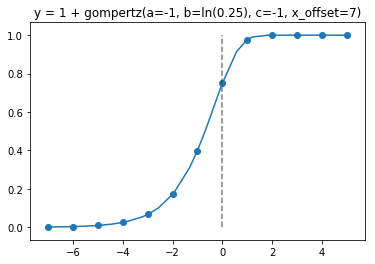

In [21]:
u_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
q = 7
c = 1

import math

ys = []
xs = []
xscat = []
yscat = []
the_range = numpy.linspace(u_list[0], u_list[-1], 20)
print(the_range)
for u in numpy.unique(u_list + list(the_range)):
    print(u)
#     gomp = 1 - numpy.exp(-numpy.log(0.75)*numpy.exp(-c*(q - u)))
    #a*exp(b*exp(c*dif))
    gomp = 1-math.exp( math.log(0.25) * math.exp(-(q-u)))
    print(u-q, gomp)
    if u in u_list:
        xscat.append(u-q)
        yscat.append(gomp)
    xs.append(u-q)
    ys.append(gomp)
plt.plot(xs, ys)
plt.scatter(x=xscat, y=yscat)
plt.title("y = 1 + gompertz(a=-1, b=ln(0.25), c=-1, x_offset=7)")
plt.vlines(0, ymin=0, ymax=1, linestyles="--", alpha=0.5)
plt.show()

In [22]:
sixs = [str(n) for n in [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3]]
qixs = [str(n) for n in [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,3,0,1,2,3,1,2]]
hout =                  [0,0,1,1,0,1,0,1,1,0,1,0,1,1,0,0,0,1,1,0,1,0]
things = split_next_step2(sixs,qixs,hout)
(o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out), sid_six_lookup, qid_qix_lookup = things

for os,oq,och,ot in zip(o_sixs, o_qixs, o_chits, o_out):
    print(os, oq, ":", ot)
    print(och[0])
    print(och[1])
#     print(och[0] + och[1])
    print("____")

for os,oq,och,ot in zip(v_sixs, v_qixs, v_chits, v_out):
    print(os, oq, ":", ot)
    print(och[0])
    print(och[1])
#     print(och[0] + och[1])
    print("____v")

for os,oq,och,ot in zip(t_sixs, t_qixs, t_chits, t_out):
    print(os, oq, ":", ot)
    print(och[0])
    print(och[1])
#     print(och[0] + och[1])
    print("____t")

ix=0
for ts,tq in zip(t_sixs, t_qixs):
    for os,oq in zip(o_sixs, o_qixs):
        if (ts,tq) == (os,oq):
            print(ix, "found T dupe,", ts,tq)
    ix+=1
    
vx=0
for vs,vq in zip(v_sixs, v_qixs):
    print(vs,vq)
    ox=0
    for os,oq in zip(o_sixs, o_qixs):
        if (vs,vq) == (os,oq):
            print(vx,ox, "found v dupe,", vs,vq)
        ox+=1
    vx+=1

splitting in progress
4
iterating...
len of these_qids: 5
post clip len of these_qids: 5
cnt! 4
len of these_qids: 5
post clip len of these_qids: 5
cnt! 8
len of these_qids: 6
post clip len of these_qids: 6
cnt! 13
len of these_qids: 6
post clip len of these_qids: 6
cnt! 18
type not found
type not found
type not found
type not found
sid six lookup 676
qid qix lookup 786
o_chits 2904
MAX QIX is 5
0 , qix is 0
1 , qix is 1
2 , qix is 2
3 , qix is 3
0 , qix is 0
1 , qix is 1
2 , qix is 2
3 , qix is 3
0 , qix is 0
1 , qix is 1
2 , qix is 2
3 , qix is 3
4 , qix is 4
0 , qix is 0
1 , qix is 1
2 , qix is 2
3 , qix is 3
1 , qix is 1
MAX QIX is 5
4 , qix is 4
3 , qix is 3
MAX QIX is 5
4 , qix is 4
2 , qix is 2
splut - 18 2 2
max indices are:
3 2 3
4 4 4
2 4
4 1
Unknown: 2
;;;;
Unknown: 2
;;;;
0 0 : 0
[0 0 0 0 0]
[0 0 0 0 0]
____
0 1 : 0
[0 0 0 0 0]
[1 0 0 0 0]
____
0 2 : 1
[0 0 0 0 0]
[1 1 0 0 0]
____
0 3 : 1
[0 0 1 0 0]
[1 1 0 0 0]
____
1 0 : 1
[0 0 0 0 0]
[0 0 0 0 0]
____
1 1 : 0
[1 0 0 0 0]


In [23]:
a = [0, 2, 0, 0, 2]
a = numpy.array(a)
print(numpy.where(a==2))

(array([1, 4]),)


In [24]:
emb_w = 2
import gc, zlib

from collections import Counter
from keras.models import load_model
from keras.callbacks import EarlyStopping, LambdaCallback
data_to_run = [5,]
c= Counter()
for a in data_to_run:
    (tw,a0,a1, students_temp, qz_temp) = pickle.load(open(home+"/synth_data/MLTM_10000_1000_(100_1_5)_{}.p".format(a), "rb"))
    print("loaded dataset",a,":", a0,a1,tw)             
    
    n_students = 1000 # len(students2)
    n_questions = 1000 #len(questions)
    spars = 0.1

    # from keras.models import load_model
    fname = "MLTM_1000_1000_(100_1_5)_sp100_5_0"
    #   m = load_model(home+"/models/" + fname, custom_objects={'WeightClip': WeightClip})
    
    print(students_temp)
    print(qz_temp)
    
    
#     c[a] += 1

#     n_students = 500 # len(students2)
#     n_questions = 500 #len(questions)
#     students2 = students_temp[0:n_students]
#     questions = qz_temp[0:n_questions]

#     curr_min = numpy.min(students2)
#     start = curr_min - .1

#     #   pre_trained_qns = m.get_weights()[1]
#     #   print(pre_trained_qns.shape)
#     m = None

#     print(0.01**(1/3))
#     # p = 1/(1+e-z)
#     print(pr_to_spread(0.215, as_A_and_D=False))#  -1.295
#     # print(a0)

#     longitude = 12 # number of steps we assume students have been in play
#     # for s in students2:
#     #   print((s-start)/longitude)

#     students_start = numpy.zeros_like(students2) + start
#     # gammas = (students2 - start)/longitude
#     gammas = numpy.random.uniform(low=0.01, high=2.4, size=(n_students, emb_w))
#     print("Gammas:", numpy.min(gammas), numpy.max(gammas), numpy.mean(gammas), numpy.median(gammas))

#     fname = "Longitudinal_{}_{}_(100_1_5)_run={}".format(n_students, n_questions, a)
#     # try:

#     # try:
#     #   o_hits
#     # except NameError:
# #     if not o_hits:
# #     (sixs, qixs, hits, hout) = pickle.load(open(home+"/synth_data/" + fname + ".p", "rb"))
# #     (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
#     # render_student_histories(sixs, qixs, hits, hout)
#     questions = None
#     students2 = None
#     students_temp = None
#     qz_temp = None

#     # pre_trained_qns = None
#     gc.collect()
#     o_hits=[]
#     t_hits=[]

#     odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                                           max_students = 100000,
#                                                                           min_hist = 40,
#                                                                           max_hist = None)#, alternate=True, balance_training=False)
#     (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
#     print("len o_sixes", len(o_sixs))

#     n_questions = len(set(qixs))
#     n_students = len(set(sixs))

#     # raise Exception("DELIBERATE EXCEPTION CALLED")

# #     def uncomp(chits):
# #         for hix, chrow in enumerate(chits):
# #             chits[hix] = pickle.loads(zlib.decompress(chrow))
# #         chits = numpy.array(chits, dtype="uint8")
# #         return chits

# #     print("uncomping")
# #     o_hits = uncomp(o_chits)
# #     v_hits = uncomp(v_chits)
# #     t_hits = uncomp(t_chits)
# #     print("straight outta comp-ton")

#   # o_chits, v_chits, t_chits = None, None, None

#   # except:
#   # # if True:
#   #   av_sc, sixs, qixs, hits, hout = run_data(students_start, questions, gammas, model_to_train=None)
#   #   #   if s > 100:
#   #   #     break
#   #     # print(h)
#   #     # print(r)
#   #     # print("***")

#   #   gc.collect()
#   #   sixs = numpy.array(sixs, dtype="uint16")
#   #   qixs = numpy.array(qixs, dtype="uint16")
#   #   hits = numpy.array(hits, dtype="uint8")
#   #   for hix, hrow in enumerate(hits):
#   #     compd = zlib.compress(pickle.dumps(hrow))
#   #     chits[hix] = compd
#   #   hout = numpy.array(hout, dtype="uint8")
#   #   pickle.dump((sixs, qixs, chits, hout), open(home+"/synth_data/" + fname + ".p", "wb"))
#   #   chits = None

#   # for h in hits[0:10]:
#   #     print(h)

#   # raise Exception("GAR")

#   # for s,q,h,r in zip(sixs, qixs, hits, hout):
#   #   print(s,q, r)
#   # print(hout)
#   # print(int(sum(hout)))
#   # print(len(hout))
#   # raise Exception("DELIBERATE EXCEPTION CALLED")

#   # qlayer = m.get_layer("qn_embedding")
#   # print(qlayer.shape)
#   # m.get_layer("qn_embedding").set_weights(pre_trained_qns)
#   # m.get_layer("qn_embedding").trainable=False


#   # hin2 = hin #numpy.array(hin).reshape(-1,(1,1,n_questions))
#   # hout2 = numpy.array(hout).reshape(-1,1)

#     n_to_keep = 10000

#   # qixs = qixs[0:n_to_keep]
#   # sixs = sixs[0:n_to_keep]  
#   # hits = hits[0:n_to_keep]
#   # hout = hout[0:n_to_keep]

#   # n_questions = len(numpy.unique(o_qixs))
#   # n_students  = len(numpy.unique(o_sixs))



#   # n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
#   # n_students = max(max(o_sixs),max(v_sixs),max(t_sixs))+1



#   # m = generate_longitudinal_model(n_questions, n_students, emb_w, None) #pre_trained_qns[0:n_questions])

#     n_to_test = 1000 #len(hout)//10
#     test_choices = numpy.random.choice(range(len(hout)), size=n_to_test)
#   # t_in = hin2[test_choices, :]

#   # t_hits = hits[test_choices]
#   # o_hits = numpy.delete(hits, test_choices, axis=0)

#   # qs_in_trimmed_data =  numpy.unique(qixs)
#   # t_hits = numpy.array([hits[ix] for ix in test_choices])
#   # o_hits = numpy.delete(hits, test_choices, axis=0)
#   # hits=None
#   # t_hits = t_hits[:, qs_in_trimmed_data]
#   # t_hits = t_hits.reshape(-1, len(qs_in_trimmed_data))
#   # o_hits = o_hits[:, qs_in_trimmed_data]
#   # o_hits = o_hits.reshape(-1, len(qs_in_trimmed_data))

#     gc.collect()

#   # t_out = hout[test_choices, :]
#   # t_out = numpy.array([hout[ix] for ix in test_choices]).reshape(-1,1)
#   # o_out = numpy.delete(hout, test_choices, axis=0).reshape(-1,1)
#   # hout=None


#   # t_sixs = numpy.array([sixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_sixs = sixs[test_choices, :]
#   # o_sixs = numpy.delete(sixs, test_choices, axis=0).reshape(-1,1)
#   # sixs=None

#   # t_qixs = numpy.array([qixs[ix] for ix in test_choices]).reshape(-1,1)
#   # # t_qixs = qixs[test_choices, :]
#   # o_qixs = numpy.delete(qixs, test_choices, axis=0).reshape(-1,1)

#     print("MM", numpy.min(o_qixs), numpy.max(o_qixs))
#     qixs=None
  
#   # o_in  = numpy.delete(hin2, test_choices, axis=0)
  
#   # hazard_model = Model(inputs=m.input,
#   #                         outputs=m.get_layer("alphas").output)
# #         intermediate_output = intermediate_layer_model.predict([qz,sz])
       
    
    
# #         print_prs = LambdaCallback(on_epoch_end=lambda batch, logs: 
# # #                                        print(numpy.min(intermediate_layer_model.predict([qz,sz])),
# # #                                              numpy.max(intermediate_layer_model.predict([qz,sz]))))
# #                                        print(prs_model.predict([qz[0:10],sz[0:10]])))

#   # ixs = o_out > 0.5
#     ixs = [True if o_out[n]>=0.5 else False for n in range(len(o_out))]
#   # print(ixs)
#   # print(o_out[ixs])
#   # print(o_qixs[ixs])
#   # print(o_sixs[ixs])
#   # print(o_hits[ixs])
#     print_hazard = LambdaCallback(on_epoch_end=lambda batch, logs:
#                                   # print(hazard_model.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]])))
#                                   print(m.predict([o_qixs[ixs], o_sixs[ixs], o_hits[ixs]]), o_out[ixs]))

#         # print_zmask = LambdaCallback(on_epoch_end=lambda batch, logs: 
#         #                                print(z_model.predict([qz[0:10],sz[0:10]])))

#   # n_ones  = int(numpy.sum(o_out, axis=0))
#   # n_zeros = len(o_out) - n_ones

#   # n_ones =  sum([1 if o_out[n]>=0.5 else 0 for n in range(len(o_out))])
#   # n_zeros = sum([1 if o_out[n]<0.5 else 0 for n in range(len(o_out))])

# #   geschichte = m.fit([o_qixs, o_sixs, o_hits], o_out, epochs=10000, validation_split=0.01, callbacks=[es], shuffle=True, class_weight=class_weightz)

# print(type(o_sixs))
# print("finished")

loaded dataset 5 : [[1.4645131]] 3.1089039466440367 1.4084517039946103
[[ 1.37173388 -1.02864352  7.55703414 ... -1.49886535  1.53442336
   1.55596703]
 [ 2.4635658   0.53089028 -5.45221188 ... -0.74608016  2.82944632
   1.92081998]
 [ 1.55326451 -3.58004045 -1.89803685 ... -0.54779934  1.07594026
  -1.57406956]
 ...
 [ 2.1023064   2.8166152  -0.4222581  ...  2.81755714 -6.81089099
  -5.47685088]
 [-3.94892705 -1.47331223  1.72161864 ...  5.54785844  0.01453553
  -1.07487148]
 [-2.68058906  0.55106707  0.27516104 ... -0.01492254  0.32854899
  -0.09848295]]
[[-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.          -2.23522303 ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 ...
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.         ... -10.         -10.
  -10.        ]
 [-10.         -10.         -10.     

In [25]:
from keras.metrics import binary_accuracy
def gen_and_train(odata, vdata, emb_w=10, draw=False, cog_model=None, q_weight=None, monitor=None, balance_classes=True, 
                  loss=None, metrics=None, reg_w=None, dropout=0):
    from keras.callbacks import EarlyStopping, LambdaCallback

    reg=""
    
    (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out) = (odata, vdata)
    
#     emb_w = 4
    m = None
    
    config_dict = {}    
    config_dict["cog_model"] = cog_model
    config_dict["emb_w"]     = emb_w
    
#     n_ones = int(sum(numpy.ravel(numpy.round(o_out))))
#     n_zeros = len(o_out) - n_ones
#     print(len(o_out))
#     print("1s:", n_ones)
#     print("0s:", n_zeros)

# #     # minority_w = .75
#     if n_zeros > n_ones:
#         zero_w = 1.0
#         one_w = n_zeros/n_ones
#     else:
#         zero_w = n_ones/n_zeros
#         one_w = 1.0

#     class_weightz0 = {
#         0: zero_w,
#         1: one_w,
#     }
    
#     print("cw0")
#     print(class_weightz0)

    from sklearn.utils.class_weight import compute_class_weight
    class_weightz = compute_class_weight("balanced", [0,1], o_out)
    class_weightz = class_weightz / min(class_weightz)
    print("class weights:", class_weightz)
    cw0 = {}
    for cwix,cw in enumerate(class_weightz):
        cw0[cwix] = cw
    class_weightz = cw0
    print("class weights (dict):", class_weightz)
    
    # o_out = o_out.reshape(-1,1)
    o_out = o_out.astype(float)

    
    if len(o_hits.shape)==3: #operating in PFA mode with separate pass/fail histories
        n_questions = int(o_hits.shape[2])
    else: #operating in older CFA mode with just a single history
        n_questions = max(max(o_qixs),max(v_qixs),max(t_qixs))+1
        
    print("max of o_sixs is:", max(o_sixs))
    n_students = int(max(o_sixs)+1)
    print("nq, ns")
    print(n_questions, n_students)
    
    if metrics is None:
        metrics = [binary_crossentropy, binary_accuracy, mean_absolute_error, mean_squared_error, f1_loss]
#     lozz = "binary_crossentropy"
    if loss=="f1_loss":
        loss = f1_loss 
#     elif loss =="f1_loss_micro":
#         loss = f1_loss_micro

    if cog_model is None:
        raise Exception("Cog model is None - shouldn't really happen")
 
    if cog_model=="RASCH":
        m = create_RASCH_model(n_questions, n_students, 
                               loss=loss, metrics=metrics)
    elif cog_model=="PF-RASCH":
        m = create_RASCH_model(n_questions, n_students, 
                               loss=loss, metrics=metrics, pf=True, dropout=dropout)
#     elif cog_model=="MLTMz":
#         m = generate_MLTM_raw_model(n_questions, n_students, emb_w, 
#                                     loss=loss, metrics=metrics, init50=True, reg="l2")
    elif cog_model=="MLTM":
        m = generate_MLTM_raw_model(n_questions, n_students, emb_w, 
                                    loss=loss, metrics=metrics, init50=True, reg="")
    elif cog_model=="MLTMq":
        m = generate_MLTM_raw_model(n_questions, n_students, emb_w, 
                                    loss=loss, metrics=metrics, init50=True, reg="", use_q=True)        
#     elif cog_model=="MLTMdp":
#         m = generate_MLTM_raw_model(n_questions, n_students, emb_w, 
#                                     loss=loss, metrics=metrics, init50=True, reg="", double_p=True)
#     elif cog_model=="APFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="additive", scalar_a=False)
#     elif cog_model=="nqAPFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="additive", scalar_a=False, use_q=False)
#     elif cog_model=="nqAPFMz":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg="l2", mode="additive", scalar_a=False, use_q=False)
    elif cog_model=="APFM":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg, mode="additive", scalar_a=True)
    elif cog_model=="CPFM":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg, mode="conjunctive", scalar_a=True)
    elif cog_model=="CPFMv":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg, mode="conjunctive", scalar_a=False)
    elif cog_model=="PFMLTM":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg)
    elif cog_model=="PFMLTMnq":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg, use_q=False)
#     elif cog_model=="PFMLTMz":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg="l2")
#     elif cog_model=="ConcatPFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="concat", use_q=False)
#     elif cog_model=="Concat3PFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="concat3", use_q=False)
#     elif cog_model=="Concat3PFMz":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg="l2", mode="concat3", use_q=False)
#     elif cog_model=="qConcatPFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="concat", use_q=True)
#     elif cog_model=="qConcat3PFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="concat3", use_q=True)
#     elif cog_model=="qConcat3PFMz":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg="l2", mode="concat3", use_q=True)
    elif cog_model=="ClassicPFM":
        m = generate_PFA_model(n_questions, n_students, emb_w, 
                               loss=loss, metrics=metrics, reg=reg, mode="classic")
#     elif cog_model=="PercPFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="slp")
#     elif cog_model=="SigPercPFM":
#         m = generate_PFA_model(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics, reg=reg, mode="sigslp")
#     elif cog_model=="PFFNN":
#         m = generate_PFFNN(n_questions, n_students, emb_w, 
#                                loss=loss, metrics=metrics)
    elif cog_model=="MLP":
        m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                       metrics=metrics, deep=False, reg="", reg_w=0)
    elif cog_model=="MLPz":
        m = generate_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                       metrics=metrics, deep=False, reg="l2", reg_w=reg_w)
    elif cog_model=="PFMLP":
        m = generate_PFM_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                       metrics=metrics, deep=False, reg=reg, reg_w=reg_w)
    elif cog_model=="PFMLPd":
        m = generate_PFM_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                       metrics=metrics, deep=False, reg=reg, reg_w=reg_w, dropout=True)
    elif cog_model=="PFMLPz":
        m = generate_PFM_MLP_model(n_questions, n_students, emb_w, ptqs=None, loss=loss, non_neg=False, 
                       metrics=metrics, deep=False, reg="l2", reg_w=reg_w)
    elif cog_model=="AFM":
        m = create_AFM_model(n_questions, n_students, emb_w, loss=loss,
                       metrics=metrics, reg=None, ns=False)
    elif cog_model=="CFM":
        m = create_CFM_model(n_questions, n_students, emb_w, loss=loss,
                       metrics=metrics, reg=None)
    elif cog_model=="AFMns":
        m = create_AFM_model(n_questions, n_students, emb_w, loss=loss,
                       metrics=metrics, reg=None, ns=True)
    else:
        raise Exception("Unknown cognitive model {}".format(cog_model))

    # t_hits = t_hits[:, 0:n_questions]

    print("TRAINING:")
    print("Unique students:", n_students)
    print("Unique questions:", n_questions)
    print("Total activity:", len(o_out), "(",numpy.sum(o_out),")")

    print("ov shape", o_hits.shape, v_hits.shape)

    mon_mode="min"
    bl = math.inf
    if monitor=="val_accuracy":
        mon_mode = "max"
        bl = -math.inf
    elif monitor =="val_f1_metric":
        mon_mode = "max"
        bl = -math.inf
    elif monitor[-5:] == "error":
        mon_mode = "min"
        bl = math.inf
    elif monitor[-4:] =="loss":
        mon_mode = "min"
        bl = math.inf
    elif monitor == "binary_crossentropy":
        mon_mode = "min"
        bl = math.inf
        
    print("monitoring info", monitor, mon_mode)
#     es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, baseline=math.inf)
    es = EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True, mode=mon_mode, baseline=bl)
#     es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, baseline=-math.inf)
#     es = EarlyStopping(monitor="val_f1_m", patience=10, restore_best_weights=True, mode="max")

    print("check assertions")
    assert not numpy.any(numpy.isnan(o_qixs))
    assert not numpy.any(numpy.isnan(o_sixs))
    assert not numpy.any(numpy.isnan(o_hits))
    assert not numpy.any(numpy.isnan(o_out))

    twinputs = False
    print(len(m.inputs))
    print(m.inputs)
    if len(m.inputs) == 4:
        twinputs = True
    
    
    bs = len(o_out)
    
#     from keras.utils import plot_model
#     if draw:
#         print("plotting model")
#         plot_model(m, to_file=cog_model+str(emb_w)+".png", show_shapes=True, show_layer_names=True)
#         return m, None, config_dict
    

    o_qixs = o_qixs.reshape(-1,1)
    o_sixs = o_sixs.reshape(-1,1)
#     o_hits = o_hits.reshape(-1, n_questions)


    o_out = o_out.reshape(-1,1)

    v_qixs = v_qixs.reshape(-1,1)
    v_sixs = v_sixs.reshape(-1,1)
#     v_hits = v_hits.reshape(-1, n_questions)


    v_out = v_out.reshape(-1,1)

    
#     lcb = keras.callbacks.LambdaCallback(
# #         on_epoch_begin= lambda e,l: print("Begin", m.get_layer("qn_embedding").get_weights()[0]),
#         on_epoch_end= lambda e,l: print("Begin", m.get_layer("qn_embedding").get_weights()[0]),
#     )
    
#     if len(o_hits.shape) == 3:
    o_pass = o_hits[:,0].flatten().reshape(len(o_sixs), -1) #[] e[0] for e in o_hits ]
    o_fail = o_hits[:,1].flatten().reshape(len(o_sixs), -1) #[ e[1] for e in o_hits ]
    v_pass = v_hits[:,0].flatten().reshape(len(v_sixs), -1) #[ e[0] for e in v_hits ]
    v_fail = v_hits[:,1].flatten().reshape(len(v_sixs), -1) #[ e[1] for e in v_hits ]

    if not twinputs:
        print("combining o_pass and o_fail counters into single o_hits, for", config_dict["cog_model"])
        o_hits = o_pass + o_fail
        v_hits = v_pass + v_fail
        otup = [o_qixs, o_sixs, o_hits]
        vtup = (v_qixs, v_sixs, v_hits)
    else:
        print("keeping separate o_pass and o_fail counters,", config_dict["cog_model"])
        otup = [o_qixs, o_sixs, o_pass, o_fail]
        vtup = (v_qixs, v_sixs, v_pass, v_fail)
                
    print("fitting")
    geschichte = m.fit(otup, o_out,
                       verbose=1,
                       batch_size=320, epochs=10000, 
#                        validation_split=0.1,
                       validation_data=(vtup, v_out), 
                       callbacks=[es], 
                       shuffle=True,
                       class_weight=(class_weightz if balance_classes else None))
    print("fertig", cog_model, emb_w, loss, monitor)
    return m, geschichte, config_dict

In [26]:
from keras.utils.layer_utils import count_params
from sklearn.metrics import log_loss
def AIC(y, y_hat, n_params, n_obs=1):
#     y_hat = model.predict(X)
#     resid = y - y_hat
#     sse = numpy.sum(numpy.power(resid,2)) / n_obs
# y_true = np.array([0, 1, 1])
# y_pred = np.array([0.1, 0.2, 0.9])

#     print(y)
#     print(y_hat)

    ll = -log_loss(y, y_hat)
    # 0.60671964791658428
#     print("LL", ll)
    k   = n_params
    aic = 2*k - 2* math.log(ll)
    return aic

def run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=False):
    from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score
    print(config_dict["cog_model"], "£MB_W", config_dict["emb_w"])
    t_sixs, t_qixs, t_hits, _ = t_data
    o_sixs, o_qixs, o_hits, _ = o_data
    p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_hits] ) )
    p_trues = t_out
    t_f1 = f1_score(p_trues, p_hats, average="macro")
    f1_micro = f1_score(p_trues, p_hats, average="micro")
    t_acc = accuracy_score(p_trues, p_hats)
    t_mae = mean_absolute_error(p_trues, p_hats)
    n_params = count_params(m.trainable_weights)
    aic = 0 #AIC(p_trues, p_hats, n_params)
    print("macro", t_f1  )
    print("micro", f1_micro)
    print( t_acc )
    print( t_mae )
    if print_clfn_report:
        from sklearn.metrics import classification_report
        print(classification_report(p_trues, p_hats))
    return t_f1, t_acc, t_mae, aic

In [27]:
import scipy
from scipy.stats import spearmanr

# def distance(a,b_list, cosine=False):
# #     return numpy.sqrt(numpy.sum(numpy.power(a-b,2)))
#     a = numpy.array(a).reshape(1,-1)
#     if not cosine:
#         #return scipy.spatial.distance.euclidean(a,b)
#         return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")
#     else:
#         dasErgebnis = scipy.spatial.distance.cdist(a,b_list, metric="cosine")
# #         for x in reswlt.flatten():
# #             if math.isnan(x):
# #                 print("Nan is cosine distance result")
# #                 print(a)
# #                 print(list(b_list))
# #                 raise Exception("NAN in cos distance")
#         if numpy.isnan(numpy.sum(dasErgebnis)):
#             dasErgebnis = numpy.nan_to_num(dasErgebnis, copy=False, nan=1.0, posinf=None, neginf=None)
#         return dasErgebnis

    
def distance(a, b_list):
    a = numpy.array(a).reshape(1,-1)
    b_list = numpy.array(b_list).reshape(-1,a.shape[1]) # len(b_list) x width(a)
    return scipy.spatial.distance.cdist(a,b_list, metric="euclidean")
    

# flax1 = [
#     [1,2,3],
#     [1,2,3],
#     [1,3,10]
# ]

# flax2 = [
#     [1,2,5],
#     [1,5,3],
#     [5,3,10],
#     [6, 7, 8]
# ]

# flax1 = numpy.array(flax1)
# flax2 = numpy.array(flax2)

# zero_pt = min(numpy.min(flax1), numpy.min(flax2))
# flax1 -= zero_pt
# flax2 -= zero_pt

# print(flax1)
# print(flax2)

# for row in flax1:
#     print(distance(row, flax2))

In [28]:
   
def build_adjacency_matrix(points_list, cosine=False):
    dim = len(points_list) # num of points is the dim of the adj_mx
#     print("dim is", dim)
    flat_dmx = [] # numpy.zeros((dim,dim)) # empty mx
    
    for a_ix in range(dim-1):
        a = points_list[a_ix]
#         print(a_ix, "a\n",a)
        to_comp = points_list[a_ix+1:]
#         print("# to comp")
#         print(len(to_comp))
#         print(to_comp)
        ds = distance(a, to_comp).ravel()
#         print("# little ds", len(ds))
#         print(ds)
        flat_dmx.extend(list(ds))
#     flat_dmx = list(numpy.array(flat_dmx).ravel())
    
    
#     for ax,a in enumerate(points_list):
#         for bx,b in enumerate(points_list):
#             if ax<bx: #only fill in the top right triangle of the matrix
#                 flat_dmx.append(distance(a,b, cosine=cosine))
# #                 adj_mx[ax,bx] = distance(a,b)
    print("flat dmx length is ", len(flat_dmx))
    return flat_dmx


def find_pairwise_rbo_in_adj_mx_list(adj_mx_list):
    ranking_list = []
    for amx in adj_mx_list:
#         rankings = list(numpy.argsort(amx))
        rankings = amx
        ranking_list.append(rankings)
    
    rbos = []
    seen = set()
    for ix,r1 in enumerate(ranking_list):
        for jx,r2 in enumerate(ranking_list):
            if ix!=jx:
                if ((ix,jx) not in seen) and ((jx,ix) not in seen):
#                     print("r1", r1)
#                     print("r2", r2)
                    this_rbo = spearmanr(r1, r2)[0]
#                     this_rbo = rbo_score(r1, r2, p=0.98)
                    rbos.append(this_rbo)
                    seen.add((ix,jx))
                    seen.add((jx,ix))

    print("correlations", rbos)
    mean_rbo = numpy.mean(rbos)
#     median_rbo = numpy.median(rbos)
    sd_rbo = numpy.std(rbos)
    return mean_rbo, sd_rbo

In [29]:
# from sklearn.preprocessing import MinMaxScaler
# def compare_adj_matrices(adj_mcs, handle=None):
    
#     vr, sd = find_pairwise_rbo_in_adj_mx_list(adj_mcs)
    
#     max_val=0
#     for m in adj_mcs:
#         this_max = numpy.amax(m)
#         if this_max>max_val:
#             max_val = this_max
#     if max_val == 0:
#         raise Exception("Distance matrix is all zeros")
            
#     flattened_mxs = adj_mcs
# #     mean_dist = numpy.mean(adj_mcs)
    
#     if handle:
#         print("For", handle)
#     print("number of flattened adj mxs = ", len(flattened_mxs))
#     print("number of elements per flattened mx = ", len(flattened_mxs[0]))
#     print("distances min/max/mu/med:", numpy.min(adj_mcs), numpy.max(adj_mcs), numpy.mean(adj_mcs), numpy.median(adj_mcs))

#     print("Average var       =", vr, "({})".format(sd))
# #     print("Norm Av var       =", n_vr)
# #             print("Norm/d corr/n Med =", correltn_md)
# #             print("Norm/d corr/n Mean=", correltn_mn)
#     return vr, sd, 0, 0 #TODO deprecate these zeroes

In [30]:
# # mx1 = [ [3, 3], [3, 5], [3,3], [5,8] ]
# mx1 = [ [2, 3], [4, 5], [1,1], [1,1] ]
# mx2 = [ [2, 3], [4, 5], [1,1], [1,1] ]

# # mx1 = [[4],[3],[2],[1],[0]]
# # mx2 = [[0],[1],[1],[1],[4]]

# ad1 = build_adjacency_matrix(mx1)
# ad2 = build_adjacency_matrix(mx2)

# # ad1 = [[0],[2],[1]]
# # ad2 = [[2],[1],[0]]
      
# print("ad1", ad1)
# print("ad2", ad2)

# compare_adj_matrices( [ad1, ad2] )

# # list1 = ['a','b','c','d','e']
# # list2 = ['b','a','c','d','e']
# # list3 = ['a','b','c','e','d']
    
# # score1 = rbo_score(list1, list2)
# # print(score1)
# # # assert score1 == 0.8
# # score2 = rbo_score(list1, list3)
# # print(score2)
# # # assert score2 == 0.95



In [31]:
numpy.random.seed(666)
n_to_comp = 100
mx_side = 2
orig  = numpy.random.randint(0,100, size=(mx_side, mx_side))
samez = [ orig ] * n_to_comp
randz = [ orig ] + [ numpy.random.randint(0,100, size=(mx_side, mx_side)) for _ in range(n_to_comp-1) ]
scalz = [ orig*(i+1) for i in range(n_to_comp) ]

print("orig")
print(orig)

# print("random")
# print(randz)

# print("scaled")
# print(scalz)

samez_flat = [numpy.ravel(s) for s in samez]
# print(samez_flat)
sp_r = spearmanr( samez_flat, axis=0 )
print("samez:\n",sp_r)
print(sp_r[0].shape)

randz_flat = [numpy.ravel(r) for r in randz]
# print(randz_flat)
sp_r = spearmanr(randz_flat, axis=0)
print("randz:\n", sp_r)
print(sp_r[0].shape)

scalz_flat = [numpy.ravel(c) for c in scalz]
# print(scalz_flat)
sp_r = spearmanr( scalz_flat, axis=0)
print("scalz:\n",sp_r)


orig
[[ 2 45]
 [30 62]]
samez:
 SpearmanrResult(correlation=array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]]), pvalue=array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]]))
(4, 4)
randz:
 SpearmanrResult(correlation=array([[ 1.        ,  0.00834949, -0.05825257,  0.03508272],
       [ 0.00834949,  1.        , -0.02431038, -0.01282159],
       [-0.05825257, -0.02431038,  1.        ,  0.13143306],
       [ 0.03508272, -0.01282159,  0.13143306,  1.        ]]), pvalue=array([[0.        , 0.93429159, 0.56482397, 0.72894962],
       [0.93429159, 0.        , 0.81026602, 0.89924979],
       [0.56482397, 0.81026602, 0.        , 0.19241477],
       [0.72894962, 0.89924979, 0.19241477, 0.        ]]))
(4, 4)
scalz:
 SpearmanrResult(correlation=array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]]), pvalue=array([[0., 0., 0.,

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [32]:
def process_history_results(history_results, o_data, t_data):
    import copy 
    rankin = []
    max_acc = -math.inf
    
    for item in history_results:
#     config_dict, m, h = item
        config_dict, m, h = item
        config_dict = copy.copy(config_dict)
        cog_model = config_dict["cog_model"]
        emb_w = config_dict["emb_w"]
        try:
            q_weight = config_dict["q_weight"]
            config_dict["cog_model"] = config_dict["cog_model"] + " " + str(emb_w) + " " + str(q_weight)
        except:
            pass
#             raise Exception("No such key: q_weight")

        v_loss = h.history["val_loss"]
        v_acc  = h.history["val_accuracy"]
        v_mse   = h.history["val_mean_absolute_error"]
        o_loss   = h.history["loss"]
        o_acc    = h.history["accuracy"]
        o_mse    = h.history["mean_absolute_error"]
        plot_acc = v_acc#[0:-10]
        plot_loss = v_loss#[0:-10]
        plot_mse = v_mse#[0:-10]

        t_acc, t_mae = run_acc_mae_test(m, o_data, t_data, config_dict)

        mod_name = cog_model +" "+ str(emb_w)
        try:
            mod_name = mod_name + " "+ str(q_weight)
        except:
            pass
        
        tup = (t_mae, t_acc, min(v_mse), max(v_acc), mod_name)
        rankin.append( tup ) 
        if max_acc < max(v_acc):
            max_acc = max(v_acc)
            max_mod = cog_model +" "+ str(emb_w)
            min_mse = min(v_mse)
            min_loss = min(v_loss)
            best_m = m
        
    print("**", max_mod, max_acc, min_loss, min_mse)
    m = best_m
    
    rankin = sorted(rankin)
    for r in rankin:
               print(r[-1],"&", numpy.round(r[1],2),"&", numpy.round(r[0],2),"\\\\")
#         print(r[-1],"&", numpy.round(r[1],2),"({})".format(numpy.round(r[3],2)),"&", numpy.round(r[0],2), "({})".format(numpy.round(r[2],2)),"\\\\")

In [33]:
# #####
# ## NEXT FEW CELLS: NeurIPS Compo 2020 dataset
# #####

# test_df = pandas.DataFrame.from_csv("./starter_kit/submission_templates/submission_task_1_2.csv", index_col="QuestionId")
# sids = test_df["UserId"]
# qids = test_df.index

# test_sids = set(sids)
# test_qids = set(qids)

In [34]:
# t_sixs = numpy.array([uniq_sids.index(s) for s in sids]).reshape(-1,1)
# t_qixs = numpy.array([uniq_qids.index(q) for q in qids]).reshape(-1,1)

# t_hits = []
# for six,qix in zip(t_sixs,t_qixs):
#     print(six,qix)
#     zs = last_h[six]
#     chits.append(zs)
#     zs[qix] += 1
#     print(sum(zs))
# t_hits = numpy.array(t_hits)
# t_hits = pca.transform(t_hits)

# fnm = home+"/models/" + handle.replace("/","~") + "_" + str(rep)
# m = keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False)
# results = m.predict([t_qixs, t_sixs, t_hits])

# print("----")
# for r in results:
#     print(r)

In [35]:
# raw_df = pandas.DataFrame.from_csv("./starter_kit/data/train_data/train_task_1_2.csv", index_col="QuestionId")

In [36]:
# print(test_sids)
# print(raw_df["UserId"].isin(test_sids))
# print(raw_df.index.isin(test_qids))

In [37]:
# test_relevant = raw_df.loc[ (raw_df["UserId"] in test_sids & raw_df.index in test_qids) ]
# print(len(test_relevant))

In [38]:
# test_sids = sids
# test_qids = qids

# indices = numpy.random.choice(len(raw_df), size=50000, replace=False)


# sids = raw_df["UserId"]#.iloc[indices]
# qids = raw_df.index#[indices]
# hout = raw_df["IsCorrect"]#.iloc[indices]
# print(len(sids))
# del raw_df

In [39]:
# uniq_qids = list(numpy.unique(qids))
# print(len(uniq_qids))
# qixlookup = {}
# for ix,uq in enumerate(uniq_qids):
#     qixlookup[uq] = ix
    
# chits = []
# last_h = {}

# # six_lookup = {}
# uniq_sids = list(numpy.unique(sids))
# sixlookup={}
# for ix,us in enumerate(uniq_sids):
#     sixlookup[us] = ix

# print("built lookups")
    
# for sid in uniq_sids:
#     six = sixlookup[sid]
#     last_h[six] = [0]*len(uniq_qids)

# print("init'd last_h lookup")
    
# v_indices = numpy.random.choice(len(sids), size=1000, replace=False)

# sixs = numpy.array([sixlookup[s] for s in sids])
# print("sixs remap done")
# qixs = numpy.array([qixlookup[q] for q in qids])
# print("qixs remap done")
# hout = numpy.array(hout)
# print("EOND")

In [40]:
# heu = generate_heu_autoencoder(len(uniq_qids), 100)
# es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        
# for six,qix in zip(sixs,qixs):
#     print(six,qix)
#     zs = last_h[six]
#     chits.append(zs)
#     zs[qix] += 1
#     print(sum(zs))
    
#     if len(chits > 1000):
#         heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(chits), shuffle=True)
#         chits = []
# heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(chits), shuffle=True)    

In [41]:
# from sklearn.decomposition import PCA #TruncatedSVD
# pca = PCA(n_components=100)
# chits = pca.fit_transform(chits)

In [42]:
# v_sixs = sixs[v_indices].reshape(-1,1)
# v_qixs = qixs[v_indices].reshape(-1,1)
# v_out = hout[v_indices]#.reshape(-1,1)
# v_hits = numpy.array(chits)[v_indices]

# print(v_indices)

# o_sixs = numpy.delete(sixs,v_indices).reshape(-1,1)
# print(len(o_sixs))
# o_qixs = numpy.delete(qixs, v_indices).reshape(-1,1)
# o_out = numpy.delete(hout, v_indices)#.reshape(-1,1)
# o_hits = numpy.delete(numpy.array(chits), v_indices, axis=0)

# print(o_sixs.shape)
# print(o_qixs.shape)
# print(o_out.shape)
# print(o_hits.shape)

# n_questions = len(uniq_qids)
# n_students = len(uniq_sids)

# (o_data, v_data, t_data) = (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (None, None, None, None)
# data_bundle = (o_data, v_data, t_data, uniq_sids, uniq_qids)
# print("data bundled")

In [43]:
l1 = range(10)
# l2 = ["d","e","f"]
pairs = []
for ix in range(1, len(l1)):
#     jx=0
#     while jx<ix:
    for jx in range(0,ix):
        pair = l1[ix],l1[jx]
        pairs.append(pair)
        
print(pairs)
print(len(pairs))
print(len(l1)*(len(l1)-1)/2)

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]
45
45.0


In [44]:
# # o_sixs = numpy.ravel(o_sixs)
# print(o_sixs.shape)
# print(o_qixs.shape)
# print(o_out.shape)
# print(o_hits.shape)

# n_questions = len(uniq_qids)
# n_students = len(uniq_sids)


In [45]:
seen = None
# max_s = 250000
# dataset_name = "examliftb1"+str(max_s)
# fnm = home+"/"+work_dir+"/" + dataset_name
max_s = 100000
dataset_name = "examliftb1"#+str(max_s)
fnm = home+"/models/" + dataset_name
print(fnm)
with open(fnm, 'rb') as f:
     data_bundle = pickle.load(f)
        
        
# data_bundle = None
# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
# (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)


(o_data, v_data, t_data, sid_six_lookup, qid_qix_lookup) = data_bundle
(o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)

# print(numpy.array(o_hits).shape)
# print(numpy.array(v_hits).shape)
# print(numpy.array(t_hits).shape)

o_hits = o_hits.astype("int8")
v_hits = v_hits.astype("int8")
t_hits = t_hits.astype("int8")

print(len(sid_six_lookup))

./models/examliftb1
1234


DATA FOUJND
GREEAT-  DATA BUNDLE ALREADY SET
GO FOR PFMLP128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 15s 18ms/step - loss: 0.8604 - binary_crossentropy: 0.8604 - binary_accuracy: 0.7352 - mean_absolute_error: 0.3432 - mean_squared_error: 0.1882 - f1_loss: 0.4647 - val

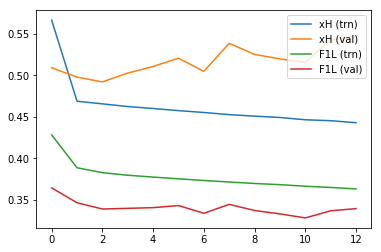

GO FOR PFMLP128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 14s 17ms/step - loss: 0.6381 - binary_crossentropy: 0.6381 - binary_accuracy: 0.7227 - mean_absolute_error: 0.3654 - mean_squared_error: 0.2001 - f1_loss: 0.4670 - val_loss: 0.5051 - val_binary_crossentropy: 0.50

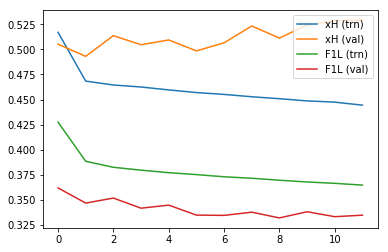

GO FOR PFMLP128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 14s 17ms/step - loss: 0.5261 - binary_crossentropy: 0.5261 - binary_accuracy: 0.7437 - mean_absolute_error: 0.3516 - mean_squared_error: 0.1746 - f1_loss: 0.4500 - val_loss: 0.5084 - val_binary_crossentropy: 0.50

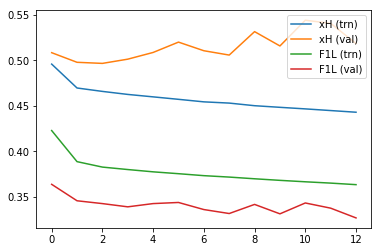

GO FOR PFMLP256//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 24s 30ms/step - loss: 0.5264 - binary_crossentropy: 0.5264 - binary_accuracy: 0.7451 - mean_absolute_error: 0.3459 - mean_squared_error: 0.1737 - f1_loss: 0.4428 - val_loss: 0.5334 - val_binary_crossentropy: 0.53

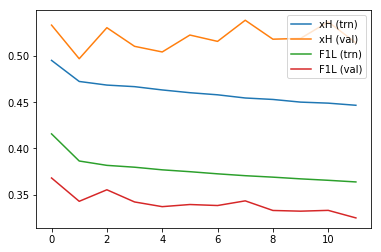

GO FOR PFMLP256//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 25s 30ms/step - loss: 0.5149 - binary_crossentropy: 0.5149 - binary_accuracy: 0.7536 - mean_absolute_error: 0.3430 - mean_squared_error: 0.1702 - f1_loss: 0.4383 - val_loss: 0.5019 - val_binary_crossentropy: 0.50

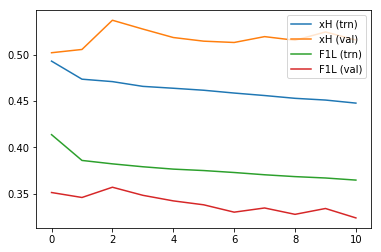

GO FOR PFMLP256//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
MLP model
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int16 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLP
fitting
Epoch 1/10000
782/782 [==============================] - 25s 31ms/step - loss: 0.6453 - binary_crossentropy: 0.6453 - binary_accuracy: 0.7297 - mean_absolute_error: 0.3503 - mean_squared_error: 0.1926 - f1_loss: 0.4568 - val_loss: 0.5057 - val_binary_crossentropy: 0.50

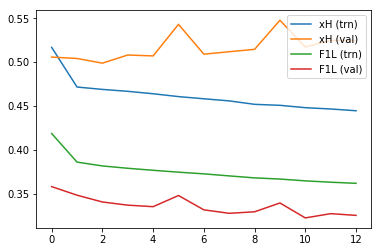

GO FOR PFMLTM128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
1131 1562
mode conjunctive
mode conjunctive created skill_diffs
USing A0, with width 128
Conj combo mode
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLTM
fitting
Epoch 1/10000
782/782 [==============================] - 11s 13ms/step - loss: 0.5906 - binary_crossentropy: 0.5906 - binary_accuracy: 0.7264 - mean_absolute_error: 0.4137 

Epoch 20/10000
782/782 [==============================] - 10s 13ms/step - loss: 0.4317 - binary_crossentropy: 0.4317 - binary_accuracy: 0.7894 - mean_absolute_error: 0.2880 - mean_squared_error: 0.1418 - f1_loss: 0.3656 - val_loss: 0.5539 - val_binary_crossentropy: 0.5539 - val_binary_accuracy: 0.7433 - val_mean_absolute_error: 0.3263 - val_mean_squared_error: 0.1768 - val_f1_loss: 0.3615
Epoch 21/10000
782/782 [==============================] - 10s 13ms/step - loss: 0.4286 - binary_crossentropy: 0.4286 - binary_accuracy: 0.7914 - mean_absolute_error: 0.2860 - mean_squared_error: 0.1407 - f1_loss: 0.3641 - val_loss: 0.5568 - val_binary_crossentropy: 0.5568 - val_binary_accuracy: 0.7317 - val_mean_absolute_error: 0.3252 - val_mean_squared_error: 0.1774 - val_f1_loss: 0.3599
Epoch 22/10000
782/782 [==============================] - 10s 13ms/step - loss: 0.4255 - binary_crossentropy: 0.4255 - binary_accuracy: 0.7926 - mean_absolute_error: 0.2841 - mean_squared_error: 0.1397 - f1_loss: 0.3

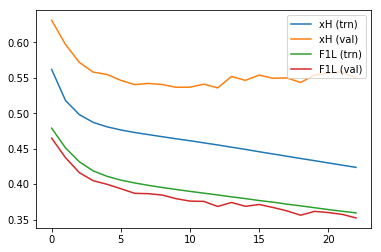

GO FOR PFMLTM128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
1131 1562
mode conjunctive
mode conjunctive created skill_diffs
USing A0, with width 128
Conj combo mode
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLTM
fitting
Epoch 1/10000
782/782 [==============================] - 12s 14ms/step - loss: 0.5918 - binary_crossentropy: 0.5918 - binary_accuracy: 0.7245 - mean_absolute_error: 0.4148 

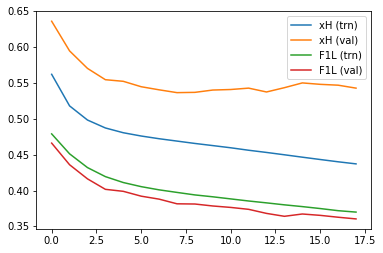

GO FOR PFMLTM128//(xe/px)#250000
class weights: [2.71871793 1.        ]
class weights (dict): {0: 2.718717929649736, 1: 1.0}
max of o_sixs is: 1561
nq, ns
1131 1562
1131 1562
mode conjunctive
mode conjunctive created skill_diffs
USing A0, with width 128
Conj combo mode
TRAINING:
Unique students: 1562
Unique questions: 1131
Total activity: 250028 ( 182793.0 )
ov shape (250028, 2, 1131) (779, 2, 1131)
monitoring info val_loss min
check assertions
4
[<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'q_select')>, <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'psi_select')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'pass_counter')>, <KerasTensor: shape=(None, 1131) dtype=float32 (created by layer 'fail_counter')>]
keeping separate o_pass and o_fail counters, PFMLTM
fitting
Epoch 1/10000
782/782 [==============================] - 12s 13ms/step - loss: 0.5905 - binary_crossentropy: 0.5905 - binary_accuracy: 0.7291 - mean_absolute_error: 0.4137 

In [ ]:
from keras.metrics import binary_accuracy, binary_crossentropy, mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score
import os
mon_lookup = {
    "binary_crossentropy" : "xe",
    "mean_squared_error"  : "mse",
    "mean_absolute_error" : "mae",
    "f1_loss" : "f1",
    "binary_accuracy" : "acc",
    "log_likelihood" : "ll",
    "loss" : "px"
}

max_s = 250000


kustom_objex = {'WeightClip': WeightClip, 'custom_avl2': custom_avl2, 'custom_avl2_inner':custom_avl2_inner},

def step_through_cog_models(sixs, qixs, hout, cog_models=None, data_bundle=None):
#     cog_models = ["MLP", "MLP+","MLTM","LFA","SLFA"]
#     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "MLTM_no_init"]
#     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "LFA","SLFA"]
    #("MLTM+",32,10,"val_f1_m",False)
    metrics = [binary_crossentropy, binary_accuracy, mean_absolute_error, mean_squared_error, f1_loss]

    if cog_models is None:
        core_models = ["CFM", "RASCH", "AFM", "MLTM"]
        variant_models = ["AFMg", "MLTMb", "MLTM0"]
#         ffnn_models = ["MLPs", "MLPsz"] #"MLP", "MLPd"]#, "CONC"]
        ffnn_models = ["MLPs", "MLP", "MLPd"]#, "CONC"]
        regd_models = [s+"z" for s in ["MLTM","MLP","MLPd","AFM","AFMg","CFM","MLTMb","MLTM0"]]
#         cog_models = variant_models
#         cog_models = regd_models
#         cog_models = ["AFM", "AFMg", "AFMx", "MLTM", "MLTMa","MLTMb", "CFM", "MLP", "MLPd"]
#         cog_models = ["MLTM"] #"MLTMb", "MLP", "CFM", "RASCH", "AFM", "AFMg", "AFMx", "MLTM", "MLTMa","MLTMb","MLTM0", "MLP", "MLPd"]
#         cog_models = ["CFM","AFM"]

#         cog_models = ["PFFNN"]#,"APFMs","APFM","MPFM","SigPercPFM","ConcatPFM","PercPFM"]
#         cog_models = ["PFFNN", "APFM", "nqAPFM", "MPFM", "MPFMz","qConcatPFM", "ConcatPFM","RASCH", "Concat3PFM", "qConcat3PFM"]
#         cog_models = ["qConcat3PFMz", "Concat3PFMz"]#, "PFMLP","PFMLPz"]
#         cog_models = ["qConcat3PFM", "Concat3PFM"]#, "PFMLP","PFMLPz"]
#         cog_models = ["PFMLPd"]#,"MLTM","MLP","ClassicPFM","PFMLTM"]
#         cog_models = ["AFMns"]#,"MLP","PFMLPz","MLPz","AFM"]
#         cog_models = ["CPFM","PFMLTMnq","CPFMv","MLTMq"]
        cog_models = ["MLTM"]
#         cog_models = ffnn_models
#         emb_ws = [400,300,256,128,64,32,16, 8]
        emb_ws = [128, 256]
#         emb_ws = [32, 64, 128, 256]
#         emb_ws = [8, 32,64,128,256] #[16,32,64]#16,32,64]
#         emb_ws = [32,64,128,256,300,400,500]

#         emb_ws = [8, 16, 32, 64, 128, 256, 300, 400,]

#         q_ws = [None]
#         losses = ["binary_crossentropy","mean_squared_error","f1_loss"]#, "binary_crossentropy"]
#         losses = [("binary_crossentropy", "val_f1_loss")]
        losses = [("binary_crossentropy", "val_loss")]#, ("binary_crossentropy", "val_f1_loss")]
#         losses = [("f1_loss", "val_f1_loss")]
        q_ws = [None]

#         monitor_settings = ["val_binary_crossentropy","val_binary_accuracy","val_mean_absolute_error", "val_mean_squared_error","val_f1_loss"]
#         monitor_settings = ["val_binary_crossentropy"]#,"val_mean_squared_error"]
#         monitor_settings = [None,]
        reg_ws = [None]#, 0.0001, 0.00001, 0.000001]#, 1000]
#         reg_ws = [0, ]#, 1000]

#         monitor_settings = ["val_mean_absolute_error", "val_mean_squared_error"]
#         monitor_settings = ["val_loss", "val_f1_m", "val_mean_squared_error"]
        balance_settings = [False]
        dropouts = [0.75, 0.8, 0.9]
#         q_ws = [None, 1, 5, 10, 50, 100, 500]
#         q_ws = [None,1,10,100,1000]
#     emb_ws = [14, ]# [1,2,4,6,8,10,12,14,16]
#     emb_ws = [1,2,4,6,8,10,12,14,16]

    n_reps =  
    
    payload = []
    
    if data_bundle is None:
        print("data_bundle is None")
        
        for strat in [True]:
            data_bundle = split_next_step2(sixs, qixs, hout, 
                                          max_students = max_s,
                                          min_hist = 40,
                                          max_hist = None,
                                          split_for_PFA=True,
                                          stratify=strat)#, alternate=True, balance_training=False)
        
        usixs_pre = numpy.unique(sixs)
        (o_data, v_data, t_data, sid_six_lookup, qid_qix_lookup) = data_bundle
        (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)

        

#         max_six = max(usixs_pre)
#         o_pass, o_fail = o_hits[:,0], o_hits[:,1]
#         v_pass, v_fail = v_hits[:,0], v_hits[:,1]
#         t_pass, t_fail = t_hits[:,0], t_hits[:,1]
#         o_pass = o_pass.reshape(1+max_six, max(qixs)+1)
#         o_fail = o_fail.reshape(1+max_six, max(qixs)+1)
#         v_pass = v_pass.reshape(1+max_six, max(qixs)+1)
#         v_fail = v_fail.reshape(1+max_six, max(qixs)+1)
#         t_pass = t_pass.reshape(1+max_six, max(qixs)+1)
#         t_fail = t_fail.reshape(1+max_six, max(qixs)+1)
        
        usixs_post= set()
        usixs_post.update(o_sixs)
        usixs_post.update(v_sixs)
        usixs_post.update(t_sixs)
        
        print("pre ", len(usixs_pre))
        print("post", len(usixs_post))
        print("^^ these are the lengths of usixs")
    else:
        print("GREEAT-  DATA BUNDLE ALREADY SET")
        
#     raise Exception("TAR")
        
#     data_bundle = [],[],[],{},{}

    odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = data_bundle
        
    f1s = []
    seen=[]
    
    save_to_disc=False
    for rep in range(n_reps):
        for cog_model in cog_models:# zip(cog_models, q_ws):
            for w in emb_ws:
                if cog_model=="RASCH" and w!=1:
                    continue
                for qw in q_ws:
                    for rw in reg_ws:
                        w0 = rw
                        for bal in balance_settings:
                            for lozz,mon in losses:
                                for do in dropouts:
                                    w1 = rw #(w*n_students)

                                    qcode = "" if (qw is None) else "q"+str(qw)    
                                    moncode = mon_lookup[mon[mon.index("_")+1:]]
                                    losscode = mon_lookup[lozz]
                                    balstr = "bal" if bal else ""

                                    handle = "{}{}/{}/{}({}/{})".format(cog_model, w, qcode, balstr, losscode, moncode)
                                    memkey = handle+str(w1)
                                    if max_s != 100000:
                                        handle += "#"+str(max_s)
                                    print("GO FOR", handle)

                                    fn = home+"/pfa_models/" + handle.replace("/","~") + "_" + str(rep)

                                    if save_to_disc:
                                        print("checking for cached file", fn)
                                        if os.path.isfile(fn):
                                            print(fn, "found")
                                            continue

                                    (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
                                    m, h, config_dict = gen_and_train(odata, vdata, draw=True, cog_model=cog_model, emb_w=w, q_weight=qw, monitor=mon, balance_classes=bal, loss=lozz, metrics=metrics, reg_w=w1, dropout=do)

                                    if len(m.inputs)==4:
                                        twinputs = True
                                    else:
                                        twinputs = False

                                    v_shits, v_fhits = v_hits[:,0], v_hits[:,1]
                                    t_shits, t_fhits = t_hits[:,0], t_hits[:,1]
                                    if twinputs:
                                        vp_hats = numpy.round( m.predict( [v_qixs, v_sixs, v_shits, v_fhits] ) )
                                        p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_shits, t_fhits] ) )
                                    else:
                                        v_allhits = v_shits + v_fhits
                                        t_allhits = t_shits + t_fhits
                                        vp_hats = numpy.round( m.predict( [v_qixs, v_sixs, v_allhits] ) )
                                        p_hats = numpy.round( m.predict( [t_qixs, t_sixs, t_allhits] ) )

                                    vp_trues = numpy.round(v_out)    
                                    v_f1 = f1_score(vp_trues, vp_hats, average="macro")
                                    p_trues = numpy.round(t_out)    
                                    t_f1 = f1_score(p_trues, p_hats, average="macro")

                                    print("F1s vt ", v_f1, t_f1)
                                    f1s.append((handle, w0, do, v_f1, t_f1))

                                    config_dict["q_weight"]=qw
                                    config_dict["monitor_value"]=mon
                                    config_dict["balance_classes"]=bal
                                    config_dict["loss"]=lozz

                                    config_dict["handle"] = handle

                                    payload.append( (config_dict, _, _) )

                                    plt.plot(h.history['loss'], label='xH (trn)')
                                    plt.plot(h.history['val_loss'], label='xH (val)')
                                    plt.plot(h.history['f1_loss'], label='F1L (trn)')
                                    plt.plot(h.history['val_f1_loss'], label='F1L (val)')
    #                                 plt.title('MAE for Chennai Reservoir Levels')
    #                                 plt.ylabel('MAE value')
    #                                 plt.xlabel('No. epoch')
                                    plt.legend(loc="upper right")
                                    plt.show()


    #                                 print("checking for cached file", fn)
    #                                 if os.path.isfile(fn):
    #                                     print(fn, "found")
    #                                     continue

                                    if save_to_disc:
                                        try:
                                            sfn = home+"/pfa_models/" + handle.replace("/","~") + "_" + str(rep)
                                            print("ATT SAVE", sfn)
                                            m.save(sfn, save_format="h5")
                                        except OSError as ose:
                                            print(ose)
                                            import shutil
                                            shutil.rmtree(fn)
                                            m.save(home+"/pfa_models/" + handle.replace("/","~") + "_" + str(rep), save_format="h5")

    #                                 if handle not in seen:
    #                                     print(handle)
    #                                     seen.append(handle)
                                
    for h, ww,do,v,t in f1s:
        print(h, ww,do,"\t", v,"\t", t)
        
    return payload, data_bundle

#########################################

# try:
#     del data_bundle
# except:
#     pass
try:
    data_bundle
    print("DATA FOUJND")
except:
    data_bundle = None
    (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))

history_results, data_bundle = step_through_cog_models(sixs, qixs, hout, data_bundle=data_bundle)
# step_through_cog_models(sixs, qixs, hout)
(o_data, v_data, t_data, sid_six_lookup, qid_qix_lookup) = data_bundle

(o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (o_data, v_data, t_data)
print(numpy.array(o_hits).shape)
print(numpy.array(v_hits).shape)
print(numpy.array(t_hits).shape)

print("PFA DATAGEN DONE")
print(max(o_qixs), max(v_qixs))

In [61]:
find_sid = {}
for k,v in sid_six_lookup.items():
    find_sid[v] = k
    
find_qid = {}
for k,v in qid_qix_lookup.items():
    find_qid[v] = k

ix=0
for ts,tq in zip(t_sixs, t_qixs):
    ox=0
    for os,oq,oo in zip(o_sixs, o_qixs, o_out):
        if (ts,tq) == (os,oq):
            print(ix,ox, "found T dupe,", find_sid[ts], find_qid[tq], ":",oo)
        ox+=1
    ix+=1
    
vx=0
for vs,vq in zip(v_sixs, v_qixs):
    ox=0
    for os,oq in zip(o_sixs, o_qixs):
        if (vs,vq) == (os,oq):
            print(vx,ox, "found v dupe,", find_sid[vs], find_qid[vq])
        ox+=1
    vx+=1

In [63]:
df = pandas.read_csv("./real_data/Worksheet_1041_ao.csv")
print(len(df))
# df = df[df.event_type=="answer_submitted"]
# df = df[df.is_correct!="(Not answered)"]

# print(len(df))
# df.to_csv("./real_data/Worksheet_1041_ao.csv")

935204


In [55]:
print(df.columns)
sixs = list(df.user_id)
qixs = df["activity_name"].map(str) + "~" + df["question_order"].map(str)
outs = df["is_correct"].map(int)

print(sixs[0:10])
print(qixs[0:10])
print(outs[0:10])

# (sixs, qixs, outs) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
pickle.dump((sixs, qixs, outs), open(home+"/real_data/XL1041.p", "wb"))

NameError: name 'df' is not defined

In [231]:
inv_qid_lookup = {}
for qid in qid_qix_lookup:
    qix = qid_qix_lookup[qid]
    inv_qid_lookup[qix] = qid

t_shits, t_fhits = t_hits[:,0], t_hits[:,1]
tup = t_sixs, t_qixs, t_shits, t_fhits, t_out
# tup = (o_sixs, o_qixs, o_hits, o_out)
for os,oq,osh,ofh,ot in zip(*tup):
    print(os, oq, inv_qid_lookup[oq], ":", ot)
    print(list(osh))
    print(list(ofh))
    #     print(sum(och[0]))
#     print(sum(och[1]))
#     print(sum(och))
#     for ochlet in och:
#         print(list(ochlet))
#     print(list(och)[0:10])
#     print(och[0] + och[1])
    print("____")

0 31 Minimal pairs 1~15.0 : 0
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

250 31 Minimal pairs 1~15.0 : 0
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

624 2 Speed reading 14~3.0 : 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [340]:
for el in t_hits:
    for el2 in el:
        print(sum(el2))
    print("__")

0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
0
1
__
0
1
__
1
0
__
0
1
__
1
0
__
0
1
__
0
1
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
0
1
__
1
0
__
1
0
__
0
1
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
1
0
__
0
1
__
0
1
__
1
0
__
0
1
__
0
1
__
0
1
__
1
0
__
1
0
__
1
0
__
0
1
__
0
1
__
0
1
__
1
0
__
0
1
__
1
0
__
0
1
__
1
0
__
0
1
__
0
1
__
0
1
__
0
1
__
1
0
__
0
1
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
0
1
__
0
1
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
0
1
__
1
0
__
0
1
__
1
0
__
0
1
__
0
1
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
1
0
__
0
1
__
0
1
__
1
0
__
0
1
__
0
1
__
0
1
__
0
1
__
1
0
__

In [46]:
dataset_name = "examliftb1" + str(max_s)
fnm = home+"/pfa_models/" + dataset_name

with open(fnm, 'wb') as f:
    pickle.dump(data_bundle, f, protocol=4)
print(fnm)

./pfa_models/examliftb1250000


In [ ]:
# EXPERIMENTAL AUTOENCODER FOR HEU
def generate_heu_autoencoder(n_questions, row_w):
    print("ROW W is ", row_w)
    # def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):  
    from keras.initializers import RandomNormal, RandomUniform, Constant
#     from keras.layers import LSTM
    
    hit = Input(shape=(n_questions, ), name="hit_counter", dtype="float32")
    h = hit

    h = Dense(row_w, name="internal_repr")(h)

    out = Dense(n_questions)(h)


    # p_LFA = σ(a_s + Σ k ∊ skills(q): 𝜸_k*n_sk - d_k)

    model = Model(inputs=[hit], outputs=out)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    print(model.summary())

    return model

In [ ]:
from keras.callbacks import EarlyStopping
n_questions = o_hits.shape[1]
heu = generate_heu_autoencoder(n_questions, 8)
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
heu.fit(o_hits, o_hits, callbacks=[es], validation_split=0.05, epochs=10000, batch_size=len(o_sixs), shuffle=True)

In [ ]:
# from sklearn.metrics import mean_absolute_error, f1_score
# o_hats = numpy.round(heu.predict(o_hits))
# # for thit, that in zip(o_hits, o_hats):
# #     list1 = "".join([str(int(abs(t))) for t in thit])
# #     list2 = "".join([str(int(abs(t))) for t in that])
# #     print(list1)
# #     print(list2)
    
# #     for t,th in zip(thit, that):
# #         print(t,th)
# #     print(thit, that)
# uniq_vals = numpy.unique(o_hits)
# print(uniq_vals)
# f1z = {}
# for val in uniq_vals:
# #     print(o_hits[o_hits==val].ravel())
#     this_f1 = mean_absolute_error(o_hits[o_hits==val].ravel(), o_hats[o_hits==val].ravel())
#     f1z[int(val)] = this_f1
# # print(mean_absolute_error(o_hits[o_hits>0].ravel(), o_hats[o_hits>0].ravel()))
# print(f1z)
# print( mean_absolute_error(o_hits.ravel(), o_hats.ravel()) )

In [ ]:
# from sklearn.metrics import mean_absolute_error
# t_hats = numpy.round(heu.predict(t_hits))
# # for thit, that in zip(t_hits, t_hats):
# #     list1 = "".join([str(int(abs(t))) for t in thit])
# #     list2 = "".join([str(int(abs(t))) for t in that])
# #     print(list1)
# #     print(list2)
    
# #     for t,th in zip(thit, that):
# #         print(t,th)
# #     print(thit, that)

# # t_hats = t_hats.ravel()
# # t_hits_flat = t_hits.ravel()

# # f1 = f1_score(t_hits.ravel(), t_hats.ravel(), average="macro")
# # acc = keras.metrics.binary_accuracy(t_hits.ravel(), t_hats.ravel())
# # print(f1, acc)
# uniq_vals = numpy.unique(t_hits)
# f1z = {}
# for val in uniq_vals:
#     this_f1 = mean_absolute_error(t_hits[t_hits==val].ravel(), t_hats[t_hits==val].ravel())
#     f1z[int(val)]=this_f1
# # print(mean_absolute_error(o_hits[o_hits>0].ravel(), o_hats[o_hits>0].ravel()))
# print(f1z)
# print( mean_absolute_error(t_hits.ravel(), t_hats.ravel()) )

In [ ]:
# print(o_hits.shape)
# seen = set()
# # uniq_hits = []
# for u in o_hits:
#     tu = tuple(u)
#     if tu not in seen:
#         seen.add(tu)
# #     else:
# #         print("dupe")

# print(len(seen))
seen = None

In [157]:
agg = defaultdict(list)
model_lookup = defaultdict(list)
max_acc = 0
handles = []

In [ ]:
# import os
# cog_models = ["MLTM","MLTMa","MLTMb", ] #,"AFM","CFM","MLP"]
# #         emb_ws = [16,]
# emb_ws = [1, 8, 64, 128, 200, 256, 300]#,48,64,80]
# #         emb_ws = [12,14,16,18,20]
# # q_ws = [None]
# #         losses = ["binary_crossentropy","mean_squared_error","f1_loss"]#, "binary_crossentropy"]
# # losses = ["binary_crossentropy"]
# # losses = [("mean_squared_error", "val_mean_squared_error")]
# losses = [("binary_crossentropy", "val_binary_crossentropy")]#,"mean_squared_error"]
# q_ws = [None, 1, 10, 100, 1000]

# #         monitor_settings = ["val_binary_crossentropy","val_binary_accuracy","val_mean_absolute_error", "val_mean_squared_error","val_f1_loss"]
# monitor_settings = ["val_binary_crossentropy"]

# balance_settings = [False, True]
# n_reps = 10
# max_s = 100000

# mon_lookup = {
#     "binary_crossentropy" : "xe",
#     "mean_squared_error"  : "mse",
#     "mean_absolute_error" : "mae",
#     "f1_loss" : "f1",
#     "binary_accuracy" : "acc",
# }

# history_results = []
# for cog_model in cog_models:# zip(cog_models, q_ws):
#     for w in emb_ws:
#         for qw in q_ws:
#             for _ in monitor_settings:
#                 for bal in balance_settings:
#                     for lozz,mon in losses:
#                         for rep in range(n_reps):
#                             cdict = {}
#                             qcode = "" if (qw is None) else "q"+str(qw)    
#                             moncode = mon_lookup[mon[mon.index("_")+1:]]
#                             losscode = mon_lookup[lozz]
#                             balstr = "bal" if bal else ""
                            
#                             handle = "{}{}/{}/{}({}/{})".format(cog_model, w, qcode, balstr, losscode, moncode)

#                             cdict["cog_model"]=cog_model
#                             cdict["emb_w"] = w
#                             cdict["q_weight"]=qw
#                             cdict["monitor_value"]=mon
#                             cdict["balance_classes"]=bal
#                             cdict["loss"]=lozz
#                             cdict["handle"] = handle
#                             cdict["rep"] = rep
#                             history_results.append(cdict)

# for item in history_results:
#     config_dict = item
# #     cog_model = config_dict["cog_model"]
# #     emb_w = config_dict["emb_w"]
# #     q_weight = config_dict["q_weight"]
# #     mon = config_dict["monitor_value"]
# #     bal = config_dict["balance_classes"]
# #     lozz = config_dict["loss"]
#     handle = config_dict["handle"]
#     rep = config_dict["rep"]
#     if max_s != 100000:
#         handle += "#"+str(max_s)
#     fnm = home+"/models/" + handle.replace("/","~") + "_" + str(rep)
#     print(handle, fnm)
    
#     if not os.path.isfile(fnm):
#         print(fnm, "not found")
#         continue
# #         raise Exception(fnm+" not found")
#     m = keras.models.load_model(fnm, custom_objects={'WeightClip': WeightClip}, compile=False)
    
# #     handle = "{}{}/{}/{}({}/{})".format(cog_model, emb_w, qcode, "bal" if bal else "", losscode,moncode)
# #     handle = "{}:w{}/q{}/{}{}({})".format(cog_model, emb_w, q_weight, mon, "/bal" if bal else "", lozz) 
#     model_lookup[handle].append(m)
#     print(fnm, handle)
#     t_f1, t_acc, t_mae, aic = run_acc_mae_test(m, o_data, t_data, config_dict, print_clfn_report=True)
    
#     agg[handle].append((t_f1, t_acc, t_mae, aic))
#     if handle not in handles:
#         handles.append(handle)

In [ ]:
# f = open(home+"/model_lookup.pkl","wb")
# pickle.dump(model_lookup,f)
# f.close()

# import csv
# print(len(agg))
# f = open(home+"/agg.txt","w")
# f.write( str(agg) )
# f.close()

In [ ]:
f1_kde={}
acc_kde={}
upto=10
for h in handles:
    pears = numpy.array(agg[h])
    f1s = [p[0] for p in pears]
    mu_f1 = numpy.mean(f1s)
    accs = [p[1] for p in pears]
    mu_acc = numpy.mean(accs)
    print(h, len(pears))
    print(pears)
#     print(av_f1, av_acc)
    print("\t", numpy.round(mu_f1,4), numpy.round(mu_acc,4))
    f1_kde[h] = f1s[0:upto]
    acc_kde[h] = accs[0:upto]

print("Plot of resultant F1 score")
# print(f1_kde)
for row in f1_kde:
    print(row)
ax1 = pandas.DataFrame(f1_kde).plot.kde(bw_method=.8, figsize=(8,8))
ax1.set_xlabel("$F_{1}$")
ax1.set_title("Distribution of prediction $F_{1}$ across models")

print("Plot of resultant F1 score")
print(acc_kde)
ax2 = pandas.DataFrame(acc_kde).plot.kde(bw_method=.8, figsize=(8,8))
ax2.set_xlabel("Accuracy")
ax2.set_title("Distribution of prediction accuracy across models")

plt.show()

In [ ]:
for h in handles:
    print(h)

In [ ]:
# def rbo_score(l1,l2,p):
#     """ 
#     Returns RBO indefinite rank similarity metric, as described in:
#     Webber, W., Moffat, A., & Zobel, J. (2010). 
#     A similarity measure for indefinite rankings. 
#     ACM Transactions on Information Systems.
#     doi:10.1145/1852102.1852106.
#     """
#     sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
#     s, S = sl
#     l, L = ll
    
#     # Calculate the overlaps at ranks 1 through l 
#     # (the longer of the two lists)
#     ss = set([])
#     ls = set([])
#     overs = {}
#     for i in range(l):
#         ls.add(L[i])
#         if i<s:
#             ss.add(S[i])
#         X_d = len(ss.intersection(ls))
#         d = i+1
#         overs[d] = float(X_d)
    
#     # (1) \sum_{d=1}^l (X_d / d) * p^d
#     sum1 = 0
#     for i in range(l):
#         d=i+1
#         sum1+=overs[d]/d*pow(p,d)
#     X_s = overs[s]
#     X_l = overs[l]

#     # (2) \sum_{d=s+1}^l [(X_s (d - s)) / (sd)] * p^d
#     sum2 = 0
#     for i in range(s,l):
#         d=i+1
#         sum2+=(X_s*(d-s)/(s*d))*pow(p,d)

#     # (3) [(X_l - X_s) / l + X_s / s] * p^l
#     sum3 = ((X_l-X_s)/l+X_s/s)*pow(p,l)
    
#     # Equation 32. 
#     rbo_ext = (1-p)/p*(sum1+sum2)+sum3
#     return rbo_ext



# def rbo_score_not_working(l1, l2, p = 0.98):
#     """
#         Calculates Ranked Biased Overlap (RBO) score. 
#         l1 -- Ranked List 1
#         l2 -- Ranked List 2
#     """
#     if l1 is None: l1 = []
#     if l2 is None: l2 = []
    
#     sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
#     s, S = sl
#     l, L = ll
#     if s == 0: return 0

#     # Calculate the overlaps at ranks 1 through l 
#     # (the longer of the two lists)
#     ss = set([]) # contains elements from the smaller list till depth i
#     ls = set([]) # contains elements from the longer list till depth i
#     x_d = {0: 0}
#     sum1 = 0.0
#     for i in range(l):
#         x = L[i]
#         y = S[i] if i < s else None
#         d = i + 1
        
#         # if two elements are same then 
#         # we don't need to add to either of the set
#         if x == y: 
#             x_d[d] = x_d[d-1] + 1.0
#         # else add items to respective list
#         # and calculate overlap
#         else: 
#             ls.add(x) 
#             if y != None: ss.add(y)
#             x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
#         #calculate average overlap
#         sum1 += x_d[d]/d * pow(p, d)
        
#     sum2 = 0.0
#     for i in range(l-s):
#         d = s+i+1
#         sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

#     sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

#     # Equation 32
#     rbo_ext = (1-p)/p*(sum1+sum2)+sum3
#     return rbo_ext
    
    
# # if __name__ == "__main__":
# list1 = ['0','1','2','3','4','5']
# # list2 = ['1','0','2','3','4','5']
# list2 = ['0','1','2','3','5','4']
# print(rbo_score(list1,list2, p = 0.98))

# list1 = ['012']
# list2 = ['012']
# print(rbo_score(list1, list2, p = 0.98))

In [ ]:
#rankin.append( (avg_f1, std_f1, avg_acc, std_acc, avg_mae, std_mae, handle) ) 
xs, ys, ups, los = [],[],[],[]
handle_filter = "AFMS"
for tup in rankin:
    handle = tup[-1]
    if not handle.startswith(handle_filter):
        continue
    if "bal" not in handle:
        continue
    print(handle)
    w = int(handle.split("/")[0][len(handle_filter):])
    y = tup[0]
    s = tup[1]
    xs.append(w)
    ys.append(y)
    ups.append(y+s)
    los.append(y-s)
xs,ys,ups,los = zip(*sorted(zip(xs, ys, ups, los)))

plt.plot(xs,ys)
plt.plot(xs,ups, linestyle="--")
plt.plot(xs,los, linestyle="--")
plt.title("ExamLift(B1) - Effect of embedding width on prediction ({})".format(handle_filter))
plt.xlabel("Embedding width")
plt.ylabel("$F_{1}$ score")
plt.show()

MLP:w32/qNone/val_f1_m/bal & 0.722 (0.01066) & 0.736 (0.01128) & 0.264 (0.01128) \\
MLP:w32/qNone/val_f1_m & 0.711 (0.00962) & 0.727 (0.00913) & 0.273 (0.00913) \\

MLP:w32/qNone/val_mean_absolute_error & 0.705 (0.00485) & 0.721 (0.00382) & 0.279 (0.00382) \\
MLP:w32/qNone/val_mean_absolute_error/bal & 0.703 (0.00599) & 0.717 (0.00525) & 0.283 (0.00525) \\
MLP:w32/qNone/val_f1_m/bal

In [ ]:
do_plot=True

plt.figure(figsize=(8,8))

for item in history_results:
    #     best_x = range(len(v_acc))[-11]
    #     plt.ylim(0,1)
    if do_plot:
        plt.plot(plot_acc, label="{} (val acc) {}".format(cog_model, emb_w))
        plt.annotate("{} (val acc) {}".format(cog_model, emb_w), (len(plot_acc), plot_acc[-1]))
    #     plt.axvline(x=best_x, ymax=max(v_acc), linestyle="--")
    #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
    #     plt.plot(plot_loss, linestyle="--", label="{} (val loss)".format(min_h))
    #     plt.plot(plot_mse, linestyle="-", label="{}".format(cog_model))
    #     plt.plot(plot_loss, linestyle="--", label="{} (loss)".format(cog_model))
    #     plt.legend(title="Cognitive Model")
    #     plt.ylabel("Validation Mean Absolute Error (Val MAE)")
        plt.ylabel("Validation Accuracy")
        plt.xlabel("Number of epochs")
        plt.title("Training of different cognitive models (Exam Lift (B1))")

#     print("**", max_mod, max_acc, min_loss, min_mse)
#     m = best_m
plt.legend()
plt.show()

In [ ]:
# def step_through_q_weights(sixs, qixs, hout):
# #     cog_models = ["MLP", "MLP+","MLTM","LFA","SLFA"]
# #     cog_models = ["MLP", "MLP+","MLTM", "MLTM+", "MLTM_no_init", "LFA","SLFA"]
#     cog_models = ["MLTM+", "MLTM+Pow"]#, "LFA", "SLFA"]
#     q_weights = [None, 1,10,100,1000 ]# [1,2,4,6,8,10,12,14,16]
#     payload = []
#     odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                               max_students = 100000,
#                                                               min_hist = 40,
#                                                               max_hist = None)#, alternate=True, balance_training=False)
#     for cog_model in cog_models:
#         for qw in q_weights:
#             (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
# #             n_students = max(o_sixs)+1
#             m, h, config_dict = gen_and_train(odata, vdata, cog_model=cog_model, q_weight=qw, emb_w=14)
#             config_dict["q_weight"] = qw
#             payload.append( (config_dict, m, h) )
#     return payload, (odata, vdata, tdata)
            

# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
# history_results, (o_data, v_data, t_data) = step_through_q_weights(sixs, qixs, hout)

# # print(o_data.shape)
# # print(v_data.shape)
# # print(t_data.shape)

# do_plot = True
# if do_plot:
#     plt.figure(figsize=(8,8))
#     for item in history_results:
#         config_dict, m, h = item
#         cog_model = config_dict["cog_model"]
#         emb_w = config_dict["emb_w"]
#         q_weight = config_dict["q_weight"]

#         v_loss = h.history["val_loss"]
#         v_acc  = h.history["val_accuracy"]
#         v_mse   = h.history["val_mean_absolute_error"]
#         o_loss   = h.history["loss"]
#         o_acc    = h.history["accuracy"]
#         o_mse    = h.history["mean_absolute_error"]
#         plot_acc = v_acc[0:-10]
#         plot_loss = v_loss[0:-10]
#         plot_mse = v_mse[0:-10]
#     #     plt.plot(plot_acc, label="{} (val acc)".format(min_h))
#     #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
#     #     plt.ylim(0.45,1)
#         to_plot = plot_loss
#         plt.plot(to_plot, linestyle="-", label="{} (val loss)".format(q_weight))
#         plt.annotate("{} {}".format(cog_model, q_weight), (len(to_plot), to_plot[-1]))
#     #     plt.plot(plot_mse, linestyle="-", label="{}".format(min_h))
#     #     plt.legend(title="Q-gate weight")
#         plt.ylabel("Validation Mean Absolute Error (Val MAE)")
#         plt.xlabel("Number of epochs")
#         plt.title("Effect of q-gate tolerance on training (Exam Lift (B1), MLP w=10)")
        
        
        

In [ ]:
# process_history_results(history_results, o_data, t_data)



MLTM+ 14 10 & 0.73 & 0.27 \\
LFA 14 None & 0.73 & 0.27 \\
SLFA 14 1000 & 0.72 & 0.28 \\
SLFA 14 10 & 0.72 & 0.28 \\
SLFA 14 None & 0.72 & 0.28 \\
SLFA 14 100 & 0.72 & 0.28 \\
LFA 14 10 & 0.72 & 0.28 \\
MLTM+ 14 100 & 0.72 & 0.28 \\
SLFA 14 1 & 0.72 & 0.28 \\
MLTM+ 14 1000 & 0.72 & 0.28 \\
LFA 14 1 & 0.71 & 0.29 \\
LFA 14 1000 & 0.71 & 0.29 \\
LFA 14 100 & 0.71 & 0.29 \\
MLTM+ 14 1 & 0.7 & 0.3 \\
MLTM+ 14 None & 0.69 & 0.31 \\

In [ ]:
# for item in history_results:
# #     config_dict, m, h = item
#     config_dict, m, h = item
#     cog_model = config_dict["cog_model"]
#     emb_w = config_dict["emb_w"]
#     run_acc_mae_test(m, o_data, t_data, config_dict)

In [ ]:
# def step_through_history_lengths(sixs, qixs, hout):
#     min_hists = [35,40,45,50,60, ]
#     max_hists = [None,]
#     payload = []
#     for min_h in min_hists:
#         for max_h in max_hists:
#             odata, vdata, tdata, sid_six_lookup, qid_qix_lookup = split_next_step(sixs, qixs, hout, 
#                                                                           max_students = 100000,
#                                                                           min_hist = min_h,
#                                                                           max_hist = max_h)#, alternate=True, balance_training=False)
#             (o_sixs, o_qixs, o_hits, o_out), (v_sixs, v_qixs, v_hits, v_out), (t_sixs, t_qixs, t_hits, t_out) = (odata, vdata, tdata)
#             m, h, _ = gen_and_train(odata, vdata, emb_w=14)
#             payload.append( (min_h, max_h, m, h) )
#     return payload
            
# (sixs, qixs, hout) = pickle.load(open(home+"/real_data/XL1041.p", "rb"))
# history_results = step_through_history_lengths(sixs, qixs, hout)

# plt.figure(figsize=(8,8))
# for item in history_results:
#     min_h, max_h, m, h = item
#     v_loss = h.history["val_loss"]
#     v_acc  = h.history["val_accuracy"]
#     v_mse   = h.history["val_mean_absolute_error"]
#     o_loss   = h.history["loss"]
#     o_acc    = h.history["accuracy"]
#     o_mse    = h.history["mean_absolute_error"]
#     plot_acc = v_acc[0:-10]
#     plot_loss = v_loss[0:-10]
#     plot_mse = v_mse[0:-10]
# #     plt.plot(plot_acc, label="{} (val acc)".format(min_h))
# #     plt.plot(plot_acc, label="{} (trn loss)".format(min_h))
#     plt.plot(plot_loss, linestyle="--", label="{} (val loss)".format(min_h))
# #     plt.plot(plot_mse, linestyle="-", label="{}".format(min_h))
#     plt.legend(title="Min. Qns. Answered")
#     plt.ylabel("Validation Mean Absolute Error (Val MAE)")
#     plt.xlabel("Number of epochs")
#     plt.title("Effect of removing short user histories on training (Exam Lift (B1), MLP w=10)")

In [ ]:
pickle.dump(((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out)), open(home+"/my_shitty_dataset.p", "wb"))
# o_chits, v_chits, t_chits = None, None, None

In [ ]:
import gc, zlib

((o_sixs, o_qixs, o_chits, o_out), (v_sixs, v_qixs, v_chits, v_out), (t_sixs, t_qixs, t_chits, t_out)) = pickle.load(open(home+"/my_shitty_dataset.p", "rb"))

print(o_chits [0:10])

# raise Exception("on purpose")
# def uncomp(chits):
#   for hix, chrow in enumerate(chits):
#     chits[hix] = pickle.loads(zlib.decompress(chrow))
#   chits = numpy.array(chits, dtype="uint8")
#   return chits
      
# print("uncomping")
# o_hits = uncomp(o_chits)
# v_hits = uncomp(v_chits)
# t_hits = uncomp(t_chits)
# print("straight outta comp-ton")

o_hits = numpy.array(o_chits)
v_hits = numpy.array(v_chits)
t_hits = numpy.array(t_chits)

o_chits, v_chits, t_chits = None, None, None


In [ ]:
m, histoire, config_dict = gen_and_train(odata, vdata, cog_model="MLP+", emb_w=14)
emb_w = config_dict["emb_w"]
cog_model = config_dict["cog_model"]
print(emb_w, cog_model)

In [ ]:
fname = home+"/longitudinal_model"
try:
# if True:
  # m.save(fname)
    m.save_weights(fname)
    print("saved, hallelujah!")
except:
  # m = keras.models.load_model(fname, custom_objects={'YATable':YATable, 'WeightClip':WeightClip })
    m = generate_longitudinal_model(n_questions, n_students, emb_w, None, loss="mse") #pre_trained_qns[0:n_questions])
    m.load_weights(fname)
    print("loaded.  Good times.")

In [ ]:
strat = [ numpy.random.choice([0,1], size=t_out.shape, p=[1/3.47,2.47/3.47]) for _ in range(100)]
rands = [ numpy.random.choice([0,1], size=t_out.shape) for _ in range(100)]

print("Baseline F1s")
print(f1_score(numpy.ones_like(t_out), t_out, average="macro"))
print(numpy.mean( [ f1_score(ayn, t_out, average="macro") for ayn in rands ] ))
print(numpy.mean( [ f1_score(s,   t_out, average="macro") for s in strat   ] ))
print("MAEs")
print(float(mean_absolute_error(numpy.ones_like(t_out), t_out)))
print(numpy.mean( [ mean_absolute_error(ayn, t_out) for ayn in rands ] ))
print(numpy.mean( [ mean_absolute_error(s,   t_out) for s in strat   ] ))

del strat
del rands

In [ ]:
min_mae = math.inf
best_w = 0

In [ ]:
print(t_sixs)
print(len(numpy.unique(t_sixs)))
print(len(numpy.unique(t_qixs)))

In [ ]:
for ix,row in enumerate(mapping.iterrows()):
    print(ix, row[0])